<pre style="color:#D00000;text-align:center;font-size:150%;font-weight:bold;font-family:Helvetica;background-color:#F9E4D0;border-style: solid;  border-color: coral; border-width: 1px;">
PRCL-0019: Sales Effectiveness & Lead Categorization – Analysis & Prediction for FicZon Inc.
</pre>

 **Business Case and Goal**

 Business Case  
FicZon Inc. is an IT solutions provider offering both on-premises and SaaS-based products. The company's primary lead generation channel is digital marketing, including website traffic, referrals, and online campaigns.  

As the market matures and competition increases, FicZon has observed a decline in sales. Currently, lead qualification is done manually by the sales team, which makes the process:  
- Time-consuming and inconsistent (depends on individual judgment).  
- Reactive instead of proactive, as categorization insights are available after the sales process rather than before.  

To improve sales effectiveness, FicZon aims to explore Machine Learning (ML) to automate lead categorization and enhance sales conversions.  

 Project Goal  
1. Data exploration insights – Sales effectiveness.  
2. ML model to predict the Lead Category (High Potential, Low Potential).

---

# Data Analysis 

### Import data

In [1]:
import chardet
import csv
import pandas as pd

file_path = (r"D:\FicZon Inc\data\raw\ficzone.csv")
with open(file_path, "rb") as f:
    raw_data = f.read(100000)  
    result = chardet.detect(raw_data)
result

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [2]:
with open(file_path, "r", encoding="ISO-8859-1") as f:
    sample = f.read(2000)  
    sniffer = csv.Sniffer()
    delimiter = sniffer.sniff(sample).delimiter
delimiter

';'

In [3]:
data = pd.read_csv(file_path, encoding="ISO-8859-1", delimiter=";")

In [4]:
from tabulate import tabulate
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

### Imports & functions

In [5]:
from insightfulpy.eda import *

In [6]:
import warnings
import logging
import time
import joblib
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import (
    chi2_contingency, fisher_exact, pearsonr, spearmanr, ttest_ind, 
    mannwhitneyu, shapiro
)
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, learning_curve, 
    StratifiedKFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, OrdinalEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, compute_class_weight, class_weight
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, balanced_accuracy_score, matthews_corrcoef, log_loss, 
    brier_score_loss, cohen_kappa_score, precision_recall_curve, 
    roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import scikitplot as skplt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor

---

In [7]:
import psutil
import os
import gc

def memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / 1024 ** 2:.2f} MB")

def dataframe_memory_usage(df):
    mem_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"DataFrame Memory Usage: {mem_usage:.2f} MB")
    return mem_usage

def garbage_collection():
    gc.collect()
    memory_usage()

In [8]:
if __name__ == "__main__":
    memory_usage()

Memory Usage: 292.02 MB


In [9]:
dataframe_memory_usage(data)

DataFrame Memory Usage: 3.87 MB


3.873668670654297

----

In [10]:
def normality_test_with_skew_kurt(df):
    normal_cols = []
    not_normal_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        col_data = df[col].dropna()
        if len(col_data) >= 3:
            if len(col_data) <= 5000:
                stat, p_value = shapiro(col_data)
                test_used = 'Shapiro-Wilk'
            else:
                stat, p_value = kstest(col_data, 'norm', args=(col_data.mean(), col_data.std()))
                test_used = 'Kolmogorov-Smirnov'
            col_skewness = skew(col_data)
            col_kurtosis = kurtosis(col_data)
            result = {
                'Column': col,
                'Test': test_used,
                'Statistic': stat,
                'p_value': p_value,
                'Skewness': col_skewness,
                'Kurtosis': col_kurtosis
            }
            if p_value > 0.05:
                normal_cols.append(result)
            else:
                not_normal_cols.append(result)
    normal_df = (
        pd.DataFrame(normal_cols)
        .sort_values(by='Column') 
        if normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    not_normal_df = (
        pd.DataFrame(not_normal_cols)
        .sort_values(by='p_value', ascending=False)  # Sort by p-value descending (near normal to not normal)
        if not_normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    print("\nNormal Columns (p > 0.05):")
    display(normal_df)
    print("\nNot Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:")
    display(not_normal_df)
    return normal_df, not_normal_df

def spearman_correlation(data, non_normal_cols, exclude_target=None, multicollinearity_threshold=0.8):
    if non_normal_cols.empty:
        print("\nNo non-normally distributed numerical columns found. Exiting Spearman Correlation.")
        return
    selected_columns = non_normal_cols['Column'].tolist()
    if exclude_target and exclude_target in selected_columns and pd.api.types.is_numeric_dtype(data[exclude_target]):
        selected_columns.remove(exclude_target)
    spearman_corr_matrix = data[selected_columns].corr(method='spearman')
    multicollinear_pairs = []
    for i, col1 in enumerate(selected_columns):
        for col2 in selected_columns[i+1:]:
            coef = spearman_corr_matrix.loc[col1, col2]
            if abs(coef) > multicollinearity_threshold:
                multicollinear_pairs.append((col1, col2, coef))
    print("\nVariables Exhibiting Multicollinearity (|Correlation| > {:.2f}):".format(multicollinearity_threshold))
    if multicollinear_pairs:
        for col1, col2, coef in multicollinear_pairs:
            print(f"- {col1} & {col2}: Correlation={coef:.4f}")
    else:
        print("No multicollinear pairs found.")
    annot_matrix = spearman_corr_matrix.round(2).astype(str)
    num_vars = len(selected_columns)
    fig_size = max(min(24, num_vars * 1.2), 10)  # Keep reasonable bounds
    annot_font_size = max(min(10, 200 / num_vars), 6)  # Smaller font for more variables
    plt.figure(figsize=(fig_size, fig_size * 0.75))
    sns.heatmap(
        spearman_corr_matrix,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        annot_kws={"size": annot_font_size},
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Spearman Correlation Matrix', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

def calculate_vif(data, exclude_target='TARGET', multicollinearity_threshold=5.0):
    # Select only numeric columns, exclude target, and drop rows with missing values
    numeric_data = data.select_dtypes(include=[np.number]).drop(columns=[exclude_target], errors='ignore').dropna()
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_data.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) 
                       for i in range(numeric_data.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    high_vif = vif_data[vif_data['VIF'] > multicollinearity_threshold]
    low_vif = vif_data[vif_data['VIF'] <= multicollinearity_threshold]
    print(f"\nVariance Inflation Factor (VIF) Scores (multicollinearity_threshold = {multicollinearity_threshold}):")
    print("\nFeatures with VIF > threshold (High Multicollinearity):")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    else:
        print("None. No features exceed the VIF threshold.")
    print("\nFeatures with VIF <= threshold (Low/No Multicollinearity):")
    if not low_vif.empty:
        print(low_vif.to_string(index=False))
    else:
        print("None. All features exceed the VIF threshold.")
    return vif_data, high_vif['Feature'].tolist()

---

## Data understanding and cleaning

FicZon Inc, an IT solution provider, faces declining sales due to an increasingly competitive market. Currently, lead categorization is performed manually by the sales team, which limits its effectiveness in real-time decision-making. While there is a process for updating lead quality, it primarily serves post-analysis rather than directly influencing conversions. The company aims to leverage machine learning to automate lead classification into high and low potential categories, anticipating improved sales effectiveness. The dataset comprises 7,422 entries with key attributes such as product ID, source, contact details, sales agent, location, delivery mode, and status. By implementing predictive analytics, FicZon seeks to enhance lead prioritization, allowing the sales team to focus on high-potential leads and improve overall conversion rates.

In [11]:
print(data.shape)
for idx, col in enumerate(data.columns):
        print(f"{idx}: {col}")

(7422, 9)
0: Created
1: Product_ID
2: Source
3: Mobile
4: EMAIL
5: Sales_Agent
6: Location
7: Delivery_Mode
8: Status


In [12]:
data.head().T

,0,1,2,3,4
Created,14-11-2018 10:05,14-11-2018 09:22,14-11-2018 09:21,14-11-2018 08:46,14-11-2018 07:34
Product_ID,NaN,NaN,NaN,NaN,NaN
Source,Website,Website,Website,Website,Website
Mobile,984XXXXXXX,XXXXXXX,XXXXXXX,XXXXXXX,XXXXXXX
EMAIL,aXXXXXXX@gmail.com,#VALUE!,dXXXXXXX@yahoo.com,wXXXXXXX@gmail.com,cXXXXXXX@gmail.com
Sales_Agent,Sales-Agent-11,Sales-Agent-10,Sales-Agent-10,Sales-Agent-10,Sales-Agent-10
Location,NaN,NaN,NaN,NaN,NaN
Delivery_Mode,Mode-5,Mode-5,Mode-5,Mode-5,Mode-5
Status,Open,Open,Open,Open,Open


In [13]:
detect_mixed_data_types(data)

'No mixed data types detected!'

In [14]:
cat_high_cardinality(data)

high_cardinality_columns


['Created', 'Source', 'Mobile', 'EMAIL']

Missing Values Summary:
            Data Type  Missing Count  Missing Percentage
Mobile         object           1810           24.386958
Product_ID    float64             58            0.781461
Location       object             58            0.781461
Sales_Agent    object             23            0.309890
Source         object             17            0.229049

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 2



<Figure size 2000x800 with 0 Axes>

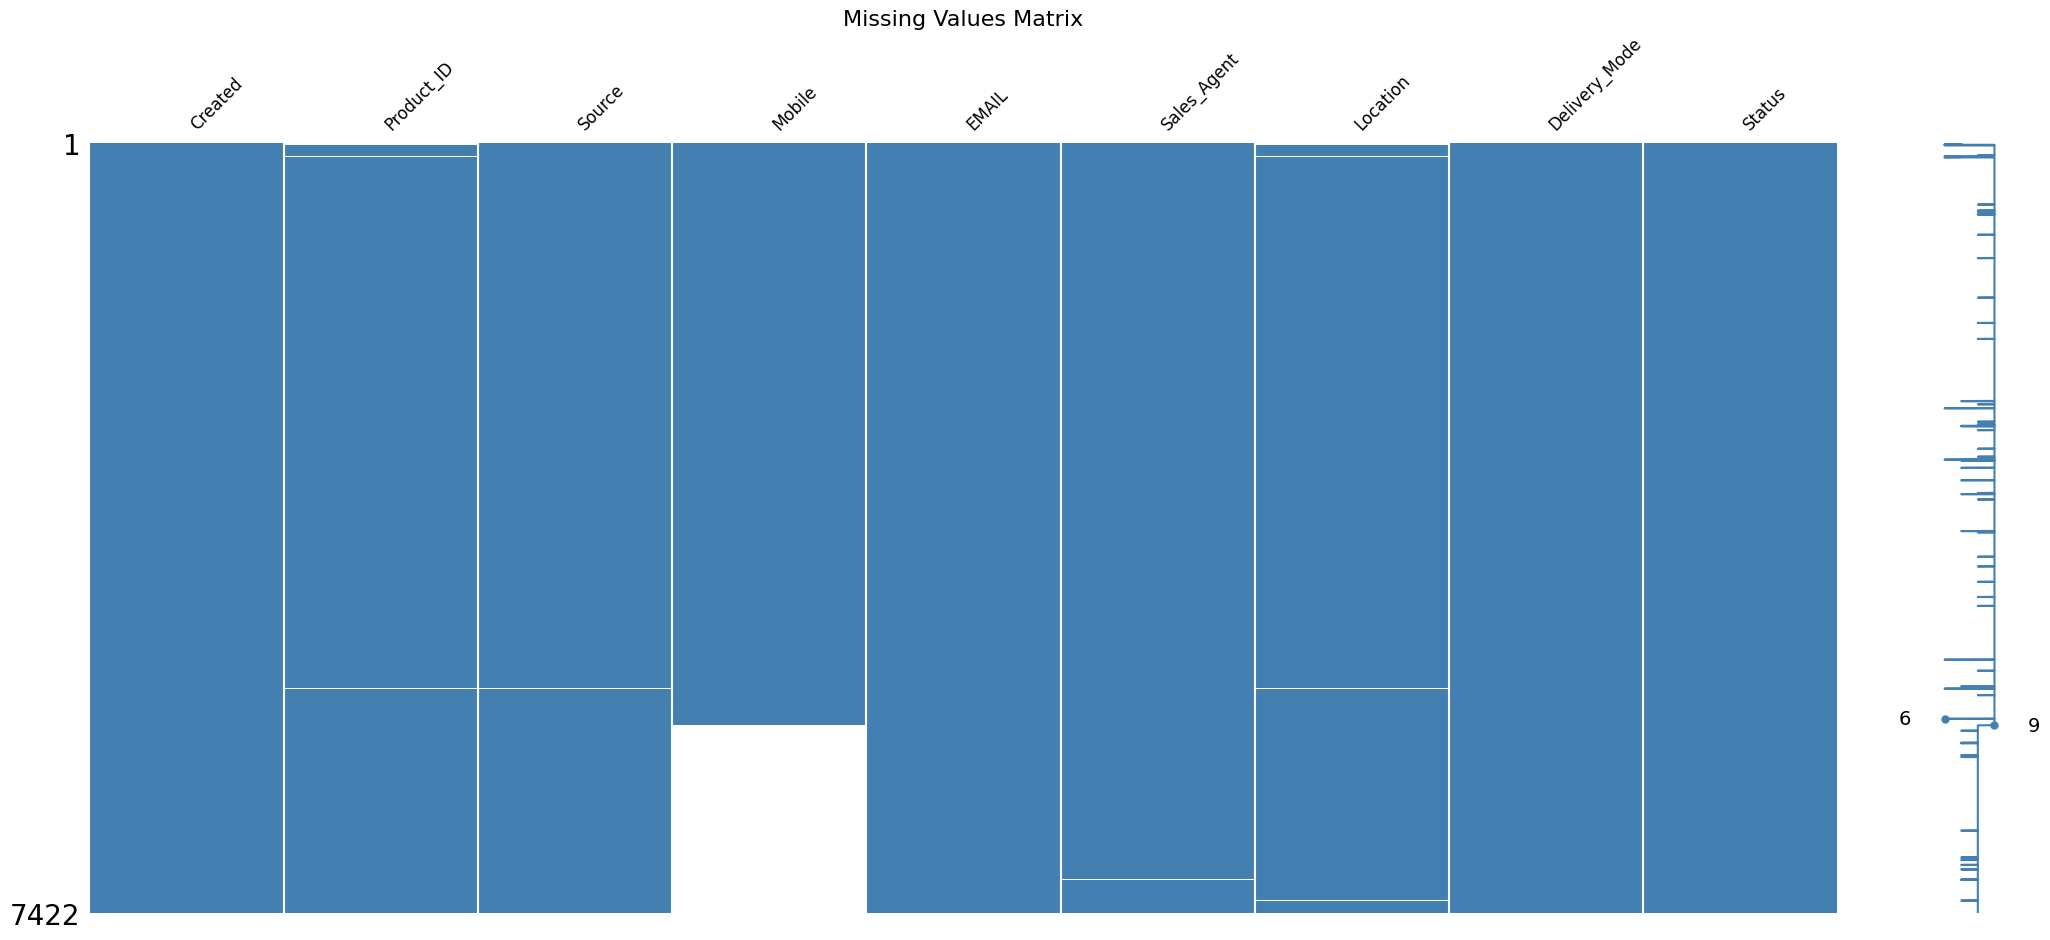

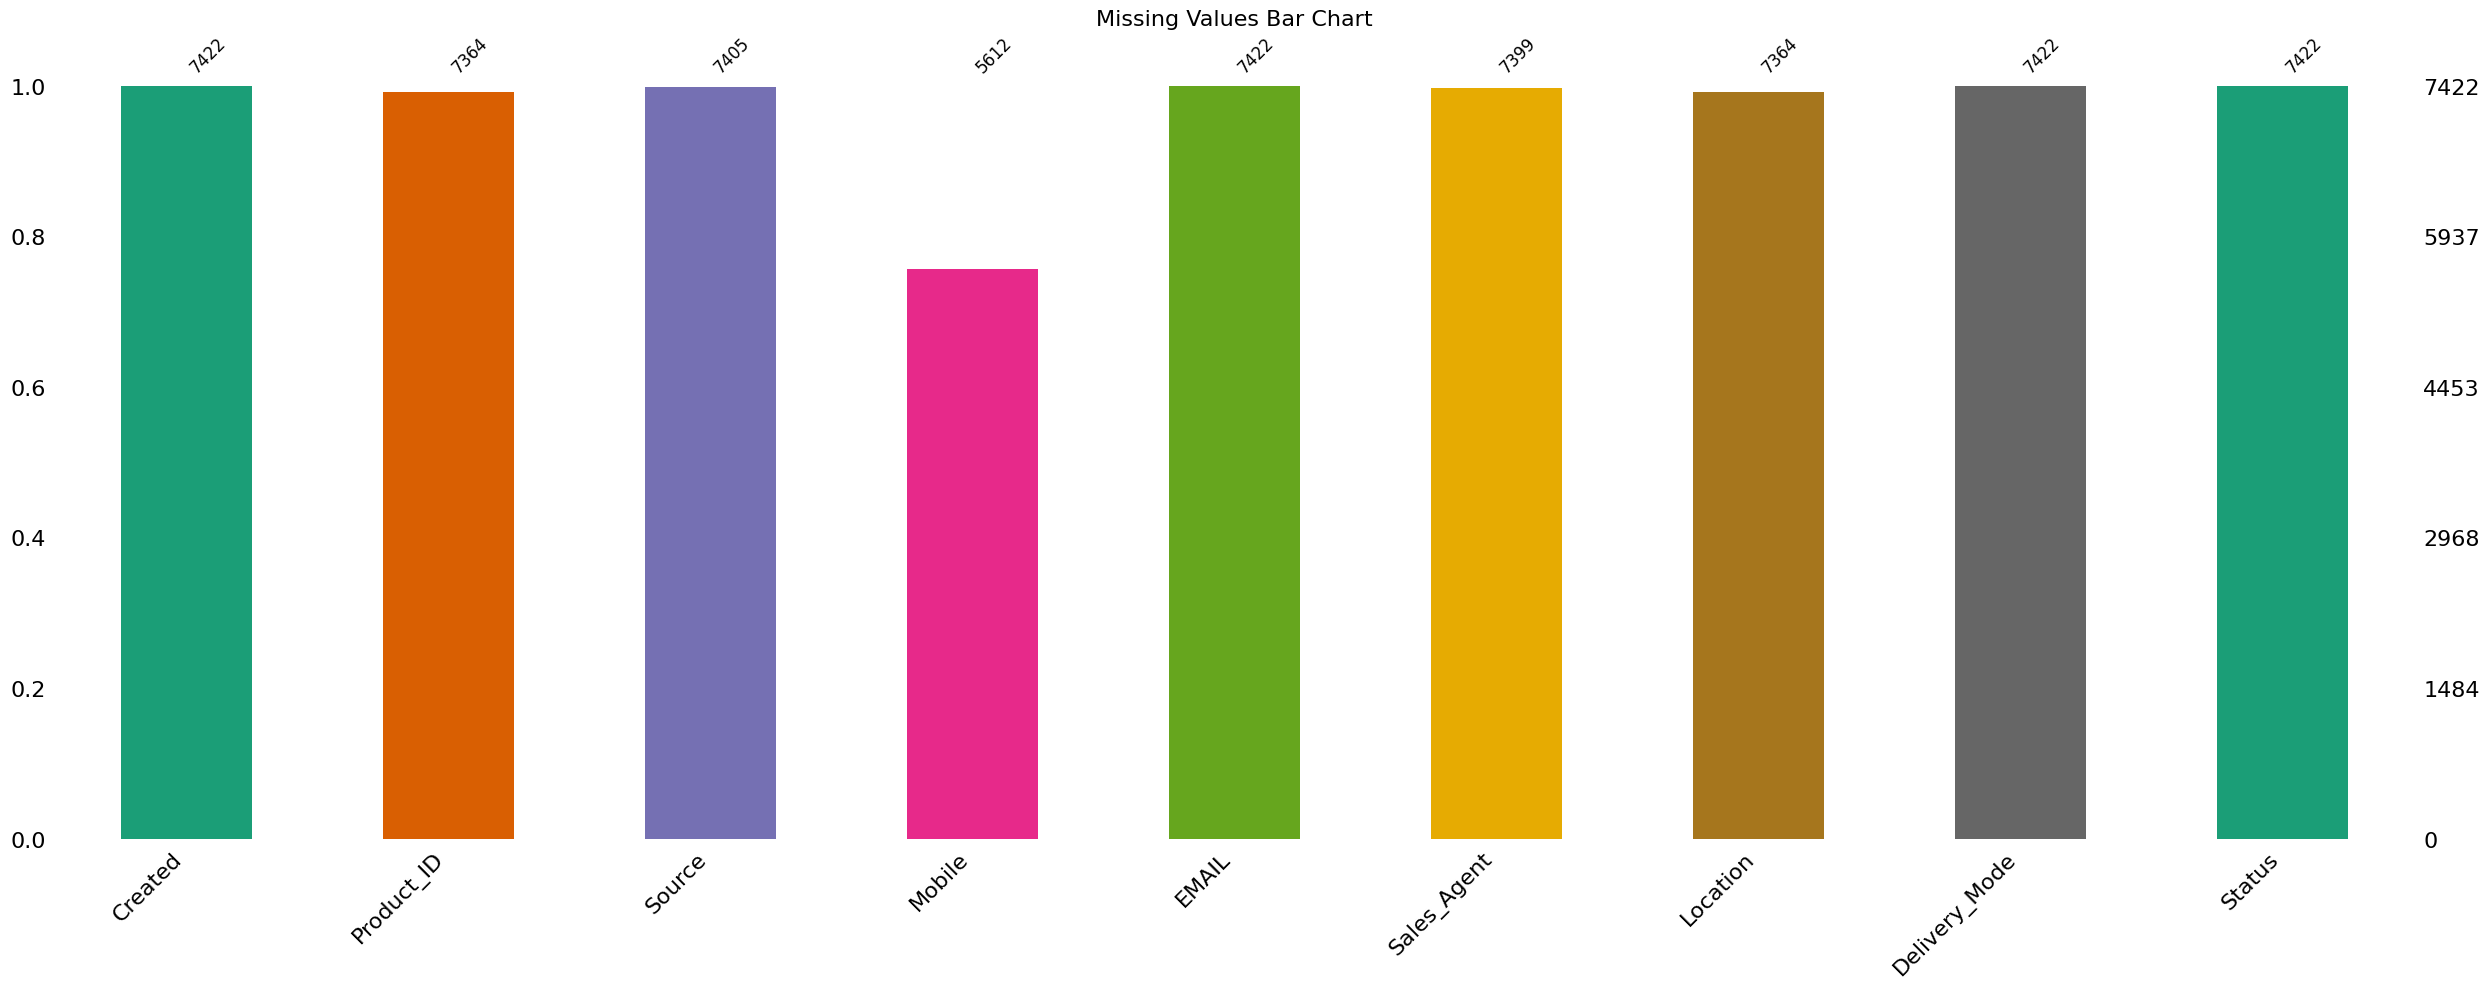

In [15]:
missing_inf_values(data)
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}\n")
duplicates = data[data.duplicated()]
duplicates
show_missing(data)

In [16]:
data = data.drop_duplicates()

In [17]:
inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum().sum()
print(f"Total Inf values: {inf_counts}")

Total Inf values: 0


In [18]:
data.dtypes.value_counts()

object     8
float64    1
Name: count, dtype: int64

In [19]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     1          Product_ID                     float64         0.0 - 28.0                     29
2     0          Created                        object          N/A                            6752
3     2          Source                         object          N/A                            25
4     3          Mobile                         object          N/A                            486
5     4          EMAIL                          object          N/A                            883
6     5          Sales_Agent                    object          N/A                            12
7     6          Location                       object          N/A                            17
8     7          Delivery_Mode                  

The dataset contains 7,422 entries with mostly categorical variables and one numerical column. High cardinality is present in Created, Source, Mobile, and EMAIL. Missing values are notable in Mobile (24.39%), while other columns have minor gaps. No infinite values were found, and duplicates are minimal. 

In [20]:
data.drop(columns=["Mobile", "Sales_Agent"], inplace=True)

In [21]:
data["Product_ID"].fillna(-1, inplace=True) 

In [22]:
data["Location"].fillna("Unknown", inplace=True)

In [23]:
data["Source"].fillna("Unknown", inplace=True)

In [24]:
missing_inf_values(data)

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.


In [25]:
data["Product_ID"] = data["Product_ID"].astype(int)
data["Created"] = pd.to_datetime(data["Created"], errors="coerce")
data.drop(columns=["EMAIL"], inplace=True)

In [26]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     0          Created                        datetime64[ns]  N/A                            6752
2     1          Product_ID                     int32           -1 - 28                        30
3     2          Source                         object          N/A                            26
4     3          Location                       object          N/A                            18
5     4          Delivery_Mode                  object          N/A                            5
6     5          Status                         object          N/A                            11


In [27]:
data["Created_Date"] = data["Created"].dt.date
data["Created_Hour"] = data["Created"].dt.hour
data["Created_DayOfWeek"] = data["Created"].dt.day_name()
data["Created_Month"] = data["Created"].dt.month_name()

To mitigate data leakage, columns such as Mobile, Sales_Agent, and EMAIL were removed, as they could inadvertently introduce unique identifiers that model predictions might rely on rather than learning generalizable patterns. Missing values were addressed by filling Product_ID with -1, while categorical features like Location and Source were assigned "Unknown" to maintain data integrity.

Post-cleaning, the dataset showed no missing or infinite values. Product_ID was converted to an integer, and Created was transformed into a datetime format to extract valuable time-based features such as Created_Date, Created_Hour, Created_DayOfWeek, and Created_Month. These derived features enhance model interpretability without introducing future information, ensuring a robust predictive setup while preventing data leakage.

In [28]:
analyze_data(data)





=== Numerical Analysis ===
|    | Variable     |    N |    Mean |     SD |     SE |   95% Conf. |   Interval |
|---:|:-------------|-----:|--------:|-------:|-------:|------------:|-----------:|
|  0 | Product_ID   | 7420 | 15.8194 | 6.2253 | 0.0723 |     15.6777 |    15.9611 |
|  1 | Created_Hour | 7420 | 13.331  | 4.0547 | 0.0471 |     13.2387 |    13.4233 |

=== Categorical Analysis ===
|     | Variable          | Outcome                       |   Count |   Percent |
|----:|:------------------|:------------------------------|--------:|----------:|
|   0 | Source            | Call                          |    2547 |     34.33 |
|   1 | Source            | Live Chat-Direct              |    1834 |     24.72 |
|   2 | Source            | Website                       |    1592 |     21.46 |
|   3 | Source            | Live Chat-Google Organic      |     274 |      3.69 |
|   4 | Source            | Live Chat -PPC                |     249 |      3.36 |
|   5 | Source            | L

In [29]:
high_potential = ["CONVERTED", "converted", "Potential", "In Progress Positive", "Long Term"]
low_potential = ["Junk Lead", "Not Responding", "LOST", "In Progress Negative", "Just Enquiry", "Open"]
data["Lead_Category"] = data["Status"].apply(lambda x: 1 if x in high_potential else 0)

The numerical analysis indicates that Product_ID values range between -1 and 28, with an average of 15.82, while the Created_Hour distribution is centered around 13.33 hours, suggesting peak activity in the early afternoon.

For categorical attributes, Source predominantly consists of calls (34.33%) and direct live chat (24.72%), indicating that customer engagement is highest through these channels. Location-wise, a significant portion of leads originates from Bangalore (28.09%) and Chennai (12.25%), while other locations are less frequent. In terms of delivery modes, Mode-5 and Mode-1 account for most interactions. The Status column reflects a broad distribution, with 20.7% classified as "Junk Lead" and 11.24% as "Converted." A new binary Lead_Category variable was introduced to categorize leads as high potential (converted or positive progress) or low potential (junk, lost, or inactive), streamlining the dataset for predictive modeling.

----

In [30]:
data_cat_missing_summary, data_cat_non_missing_summary = comp_cat_analysis(data, missing_df=True)
data_num_missing_summary, data_num_non_missing_summary = comp_num_analysis(data, missing_df=True)
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_cat_missing_summary.shape)
print(data_num_missing_summary.shape)
print(data_outlier_summary.shape)

(0, 9)
(0, 31)
(1, 31)


In [31]:
data_cat_missing_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Mode,Mode Frequency,Mode %


In [32]:
data_num_missing_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value


In [33]:
data_cat_non_missing_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Mode,Mode Frequency,Mode %
4,6,Created_Date,object,7420,0.0,201,2018-05-29,82,1.105121
5,8,Created_DayOfWeek,object,7420,0.0,7,Monday,1513,20.390836
6,9,Created_Month,object,7420,0.0,8,June,1285,17.318059
2,4,Delivery_Mode,object,7420,0.0,5,Mode-5,2973,40.067385
1,3,Location,object,7420,0.0,18,Other Locations,2500,33.692722
0,2,Source,object,7420,0.0,26,Call,2547,34.326146
3,5,Status,object,7420,0.0,11,Junk Lead,1536,20.700809


In [34]:
data_num_non_missing_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value
0,1,Product_ID,int32,7420,0.0,30,-1,10.0,18.0,19.0,28,18,29,9.0,-3.5,32.5,30,0,0,0.000000,56,1,0.754717,15.819407,38.753741,6.225250,-0.278257,-0.020157,Kolmogorov-Smirnov,0.184837,2.303003e-222
1,7,Created_Hour,int32,7420,0.0,24,0,11.0,13.0,16.0,23,11,23,5.0,3.5,23.5,24,4,185,2.493261,0,0,0.000000,13.330997,16.440365,4.054672,-0.256328,0.934939,Kolmogorov-Smirnov,0.107831,1.374900e-75
2,10,Lead_Category,int64,7420,0.0,2,0,0.0,0.0,1.0,1,0,1,1.0,-1.5,2.5,2,0,0,0.000000,0,0,0.000000,0.383962,0.236567,0.486382,0.477179,-1.772300,Kolmogorov-Smirnov,0.401106,0.000000e+00


In [35]:
data_non_outlier_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value
0,1,Product_ID,int32,7420,0.0,30,-1,10.0,18.0,19.0,28,18,29,9.0,-3.5,32.5,30,0,0,0.0,56,1,0.754717,15.819407,38.753741,6.225250,-0.278257,-0.020157,Kolmogorov-Smirnov,0.184837,2.303003e-222
2,10,Lead_Category,int64,7420,0.0,2,0,0.0,0.0,1.0,1,0,1,1.0,-1.5,2.5,2,0,0,0.0,0,0,0.000000,0.383962,0.236567,0.486382,0.477179,-1.772300,Kolmogorov-Smirnov,0.401106,0.000000e+00


In [36]:
data_outlier_summary

,Index,Column,DataType,Count,Missing_Percentage,Unique_Count,Min,Q1,50% (Median),Q3,Max,Mode,Range,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Negative Count,Negative Distinct,Negative %,Mean,Variance,Std,Skewness,Kurtosis,Normality Test,Normality Statistic,Normality p-value
1,7,Created_Hour,int32,7420,0.0,24,0,11.0,13.0,16.0,23,11,23,5.0,3.5,23.5,24,4,185,2.493261,0,0,0.0,13.330997,16.440365,4.054672,-0.256328,0.934939,Kolmogorov-Smirnov,0.107831,1.374900e-75


In [37]:
data_negative_values = data.select_dtypes(include=[np.number]).lt(0).sum()
data_negative_values = data_negative_values[data_negative_values > 0].sort_values(ascending=False)
print("Columns with Negative Values (Sorted):\n", data_negative_values)

Columns with Negative Values (Sorted):
 Product_ID    56
dtype: int64


In [38]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)


Normal Columns (p > 0.05):


,Column,Test,Statistic,p_value,Skewness,Kurtosis



Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


,Column,Test,Statistic,p_value,Skewness,Kurtosis
1,Created_Hour,Kolmogorov-Smirnov,0.107831,1.374900e-75,-0.256328,0.934939
0,Product_ID,Kolmogorov-Smirnov,0.184837,2.303003e-222,-0.278257,-0.020157
2,Lead_Category,Kolmogorov-Smirnov,0.401106,0.000000e+00,0.477179,-1.772300


The dataset appears well-structured, with no missing values detected in either numerical or categorical features. Outlier analysis identified Created_Hour as the only feature with outliers, accounting for approximately 2.49% of values, though these remain within a reasonable range. Product_ID contains 56 negative values, which were previously assigned as placeholders for missing data.

Normality tests confirmed that none of the numerical features follow a normal distribution, with all failing the Kolmogorov-Smirnov test. Lead_Category shows the highest skewness, while Created_Hour and Product_ID exhibit slight deviations from normality. The absence of missing values simplifies preprocessing, but addressing outliers in Created_Hour and interpreting the role of negative values in Product_ID will be important considerations before model training.

### Exploratory Data Analysis (EDA)

### Descriptive Statistics


Value counts and percentages for Lead_Category:

|   Lead_Category |   Count |   % Total |
|----------------:|--------:|----------:|
|               0 |    4571 |      61.6 |
|               1 |    2849 |      38.4 |


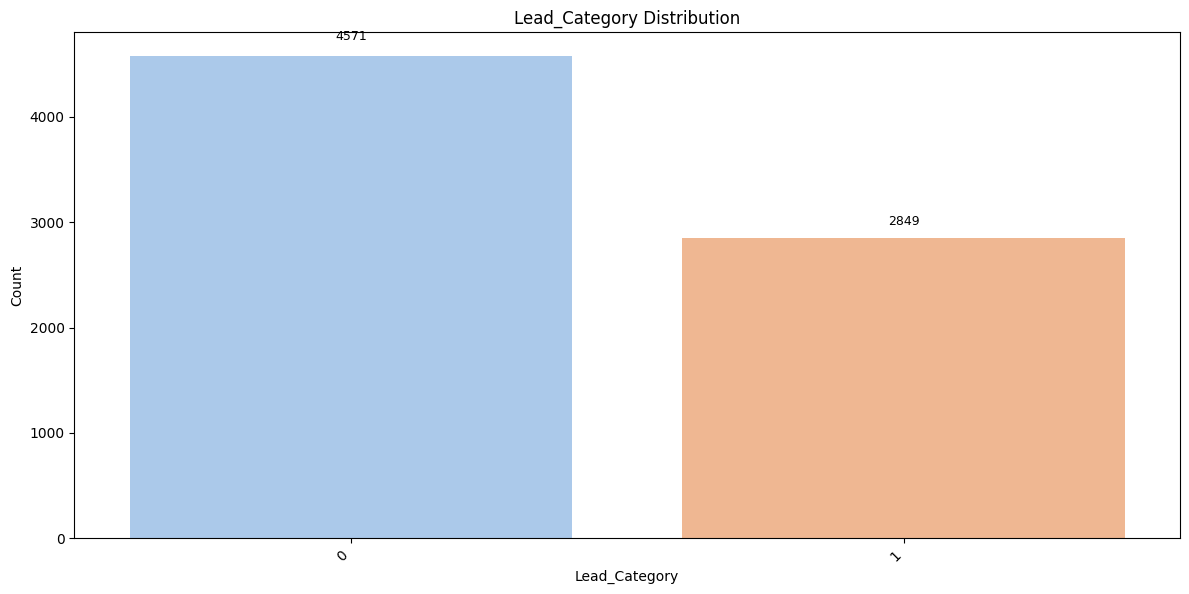

In [39]:
cat_analyze_and_plot(data, 'Lead_Category')

In [40]:
grouped_summary(data, groupby='Lead_Category')

=== Summary Grouped by 'Lead_Category' ===


Grouped by Lead_Category                                                                                                                                            
                                                                        Missing                                     Overall                                           0                                           1 P-Value
n                                                                                                                      7420                                        4571                                        2849        
Created, mean (SD)                                                            0  1533070083493261568.0 (4922547135932227.0)  1532717797186611200.0 (4833208847074206.0)  1533635299606879488.0 (5011960586957689.0)     nan
Product_ID, mean (SD)                                                         0                                  15.8 (6.2)                                  15.3 (6.2)                                  16.6 (6.2)  <0.001
Source, n (%)            By Recommendation                                                                         32 (0.4)                                     4 (0.1)                                    28 (1.0)  <0.001
                         CRM form                                                                                  23 (0.3)                                    16 (0.4)                                     7 (0.2)        
                         Call                                                                                   2547 (34.3)                                 1630 (35.7)                                  917 (32.2)        
                         Campaign                                                                                  19 (0.3)                                    11 (0.2)                                     8 (0.3)        
                         Customer Referral                                                                        180 (2.4)                                    19 (0.4)                                   161 (5.7)        
                         E-mail Campaign                                                                           12 (0.2)                                     7 (0.2)                                     5 (0.2)        
                         Existing Client                                                                           51 (0.7)                                     3 (0.1)                                    48 (1.7)        
                         Existing Customer                                                                         22 (0.3)                                     2 (0.0)                                    20 (0.7)        
                         Just Dial                                                                                 56 (0.8)                                    42 (0.9)                                    14 (0.5)        
                         Live Chat -PPC                                                                           249 (3.4)                                   154 (3.4)                                    95 (3.3)        
                         Live Chat-Adwords Remarketing                                                              7 (0.1)                                     4 (0.1)                                     3 (0.1)        
                         Live Chat-Blog                                                                           237 (3.2)                                   161 (3.5)                                    76 (2.7)        
                         Live Chat-CPC                                                                             50 (0.7)                                    38 (0.8)                                    12 (0.4)        
                         Live Chat-Direct                                                      

The dataset reveals that 38.4% of leads fall into the high-potential category, while 61.6% are classified as low-potential. The source of leads significantly impacts conversion likelihood, with customer referrals, existing clients, and direct recommendations showing higher conversion rates. In contrast, channels such as general website inquiries and certain live chat sources contribute more to low-potential leads.

Geographically, Bangalore stands out with a high share of high-potential leads (44.5%), whereas locations classified as "Other" primarily consist of low-potential leads. Delivery modes also exhibit distinct patterns, with Mode-1 linked to a higher proportion of high-potential leads (46.7%), while Mode-5 is associated with more low-potential leads (49%).

Temporal analysis suggests that conversion likelihood does not strongly vary by the day of the week, but monthly trends indicate a slightly higher concentration of high-potential leads in October and September. Product_ID shows a notable difference between lead categories, with higher values correlating to high-potential leads. Overall, the insights indicate that optimizing lead sources and focusing on high-performing channels and regions could improve sales effectiveness.

In [41]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     0          Created                        datetime64[ns]  N/A                            6752
2     1          Product_ID                     int32           -1 - 28                        30
3     7          Created_Hour                   int32           0 - 23                         24
4     10         Lead_Category                  int64           0 - 1                          2
5     2          Source                         object          N/A                            26
6     3          Location                       object          N/A                            18
7     4          Delivery_Mode                  object          N/A                            5
8     5          Status                         obje

In [42]:
num_summary(data)

,Count,Unique,Mean,Std,Min,25%,50%,75%,Max,Mode,Range,IQR,Variance,Skewness,Kurtosis,Shapiro-Wilk Stat,Shapiro-Wilk p-value
Product_ID,7420.0,30.0,15.8194,6.2253,-1.0,10.0,18.0,19.0,28.0,18.0,29.0,9.0,38.7537,-0.2783,-0.0194,0.9258,0.0
Created_Hour,7420.0,24.0,13.3310,4.0547,0.0,11.0,13.0,16.0,23.0,11.0,23.0,5.0,16.4404,-0.2564,0.9364,0.9619,0.0
Lead_Category,7420.0,2.0,0.3840,0.4864,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.2366,0.4773,-1.7727,0.6167,0.0


In [43]:
cat_summary(data)

,Count,Unique,Top,Freq,Top %
Source,7420,26,Call,2547,34.33%
Location,7420,18,Other Locations,2500,33.69%
Delivery_Mode,7420,5,Mode-5,2973,40.07%
Status,7420,11,Junk Lead,1536,20.70%
Created_Date,7420,201,2018-05-29,82,1.11%
Created_DayOfWeek,7420,7,Monday,1513,20.39%
Created_Month,7420,8,June,1285,17.32%


Product_ID ranges from -1 to 28, with an average of 15.82, while Created_Hour spans 0 to 23, with peak activity around 11 AM. The Lead_Category distribution indicates that 38.4% of leads are classified as high potential, whereas the majority fall into the low-potential category.

Among categorical variables, Call is the most common lead source (34.33%), followed by live chat and website inquiries. Other Locations account for the highest proportion of leads (33.69%), highlighting a dispersed customer base. Mode-5 is the dominant delivery mode (40.07%), while Junk Lead is the most frequent status, appearing in 20.7% of records. Temporal patterns show that most leads originate on Mondays (20.39%), with June being the most active month (17.32%).

Skewness and kurtosis values suggest slight asymmetry in numerical distributions, and normality tests confirm that none of the numerical features follow a normal distribution. The dataset is well-structured, with a strong presence of categorical variables, making feature engineering essential for optimizing predictive performance.

### Univariate Analysis

#### num_analysis

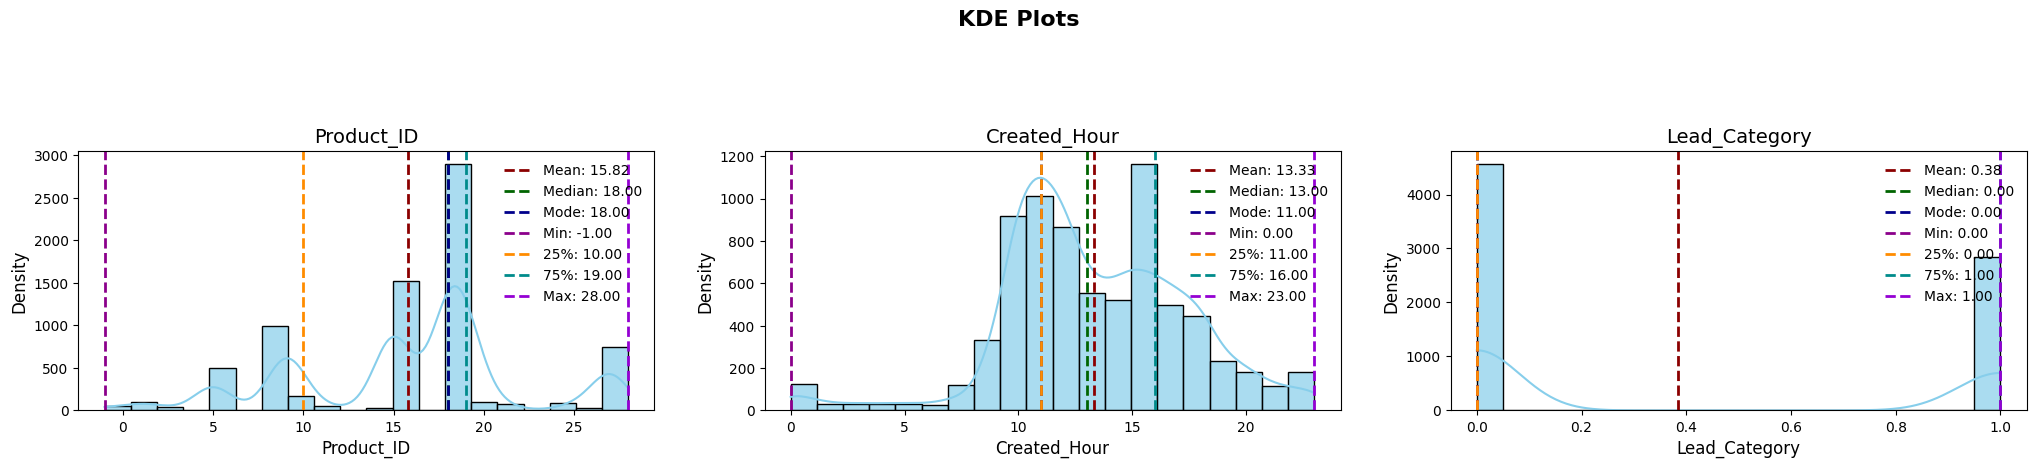

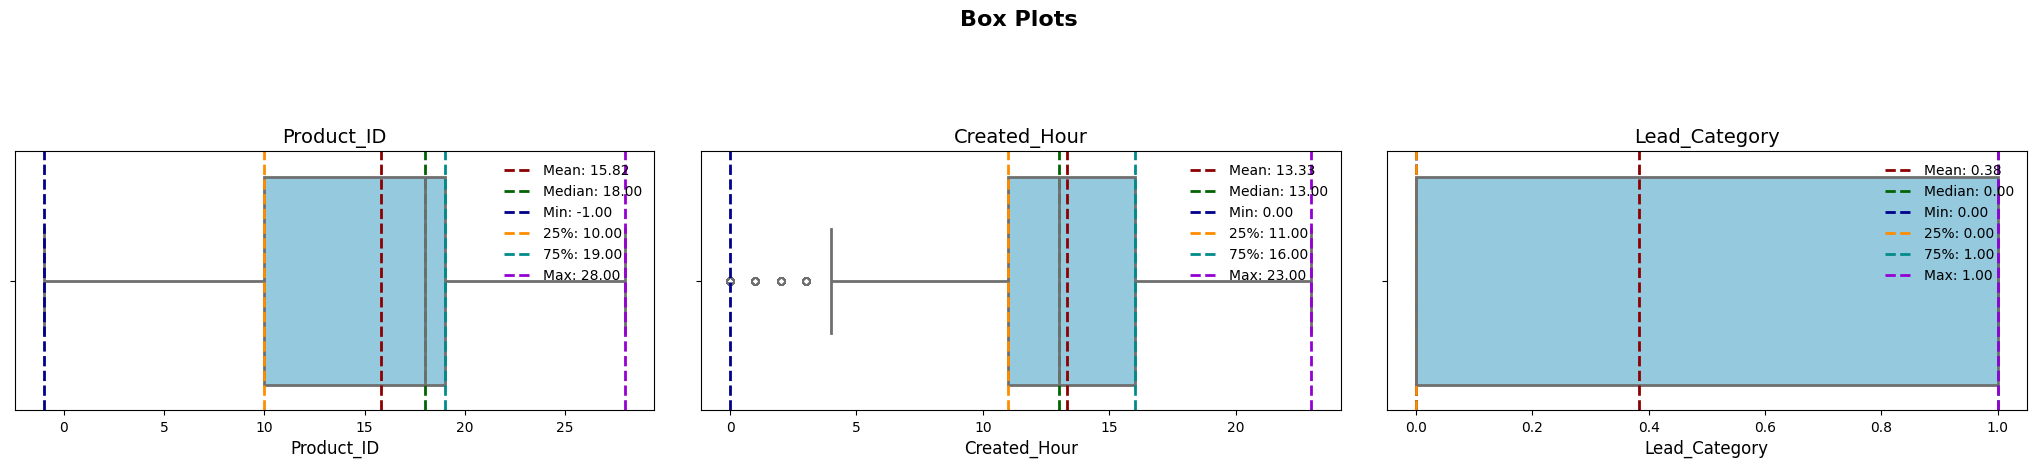

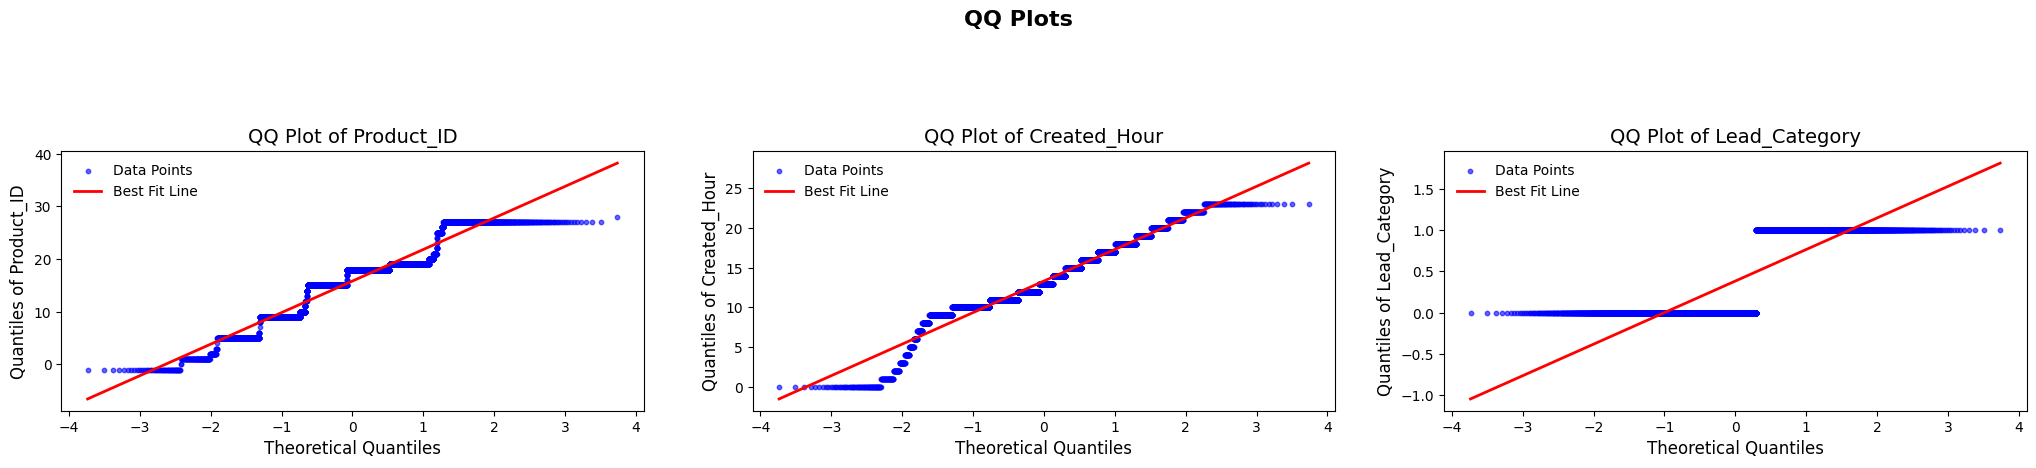

In [44]:
kde_batches(data, batch_num=1)
box_plot_batches(data, batch_num=1)
qq_plot_batches(data, batch_num=1)

The distribution of Product_ID appears multimodal, suggesting that certain IDs occur more frequently than others, with values mostly concentrated between 10 and 19. However, the presence of a negative value raises concerns about data accuracy. The Created_Hour variable follows a slightly right-skewed distribution, with most values ranging between 10 and 16 and a peak around 11, indicating that activity is concentrated within a specific time frame. The Lead_Category variable, being binary, highlights that category 0 is more prevalent than category 1. The box plots confirm the presence of outliers, particularly in Created_Hour, where a few values lie below 3.5, and in Product_ID, where the negative value stands out. The QQ plots further validate the non-normal nature of the data, with Product_ID displaying a stepped pattern, Created_Hour showing deviations from normality at lower values, and Lead_Category being inherently non-normal due to its binary nature. The overall analysis reveals irregularities in the dataset, particularly with outliers and non-normal distributions, suggesting that specific values in Product_ID and Created_Hour require closer scrutiny.

#### cat_analysis


=== Excluded or Processed Columns ===
Time Series Columns (Auto-Detected): ['Created']
High Cardinality Columns (>19 unique values): ['Source', 'Created_Date']


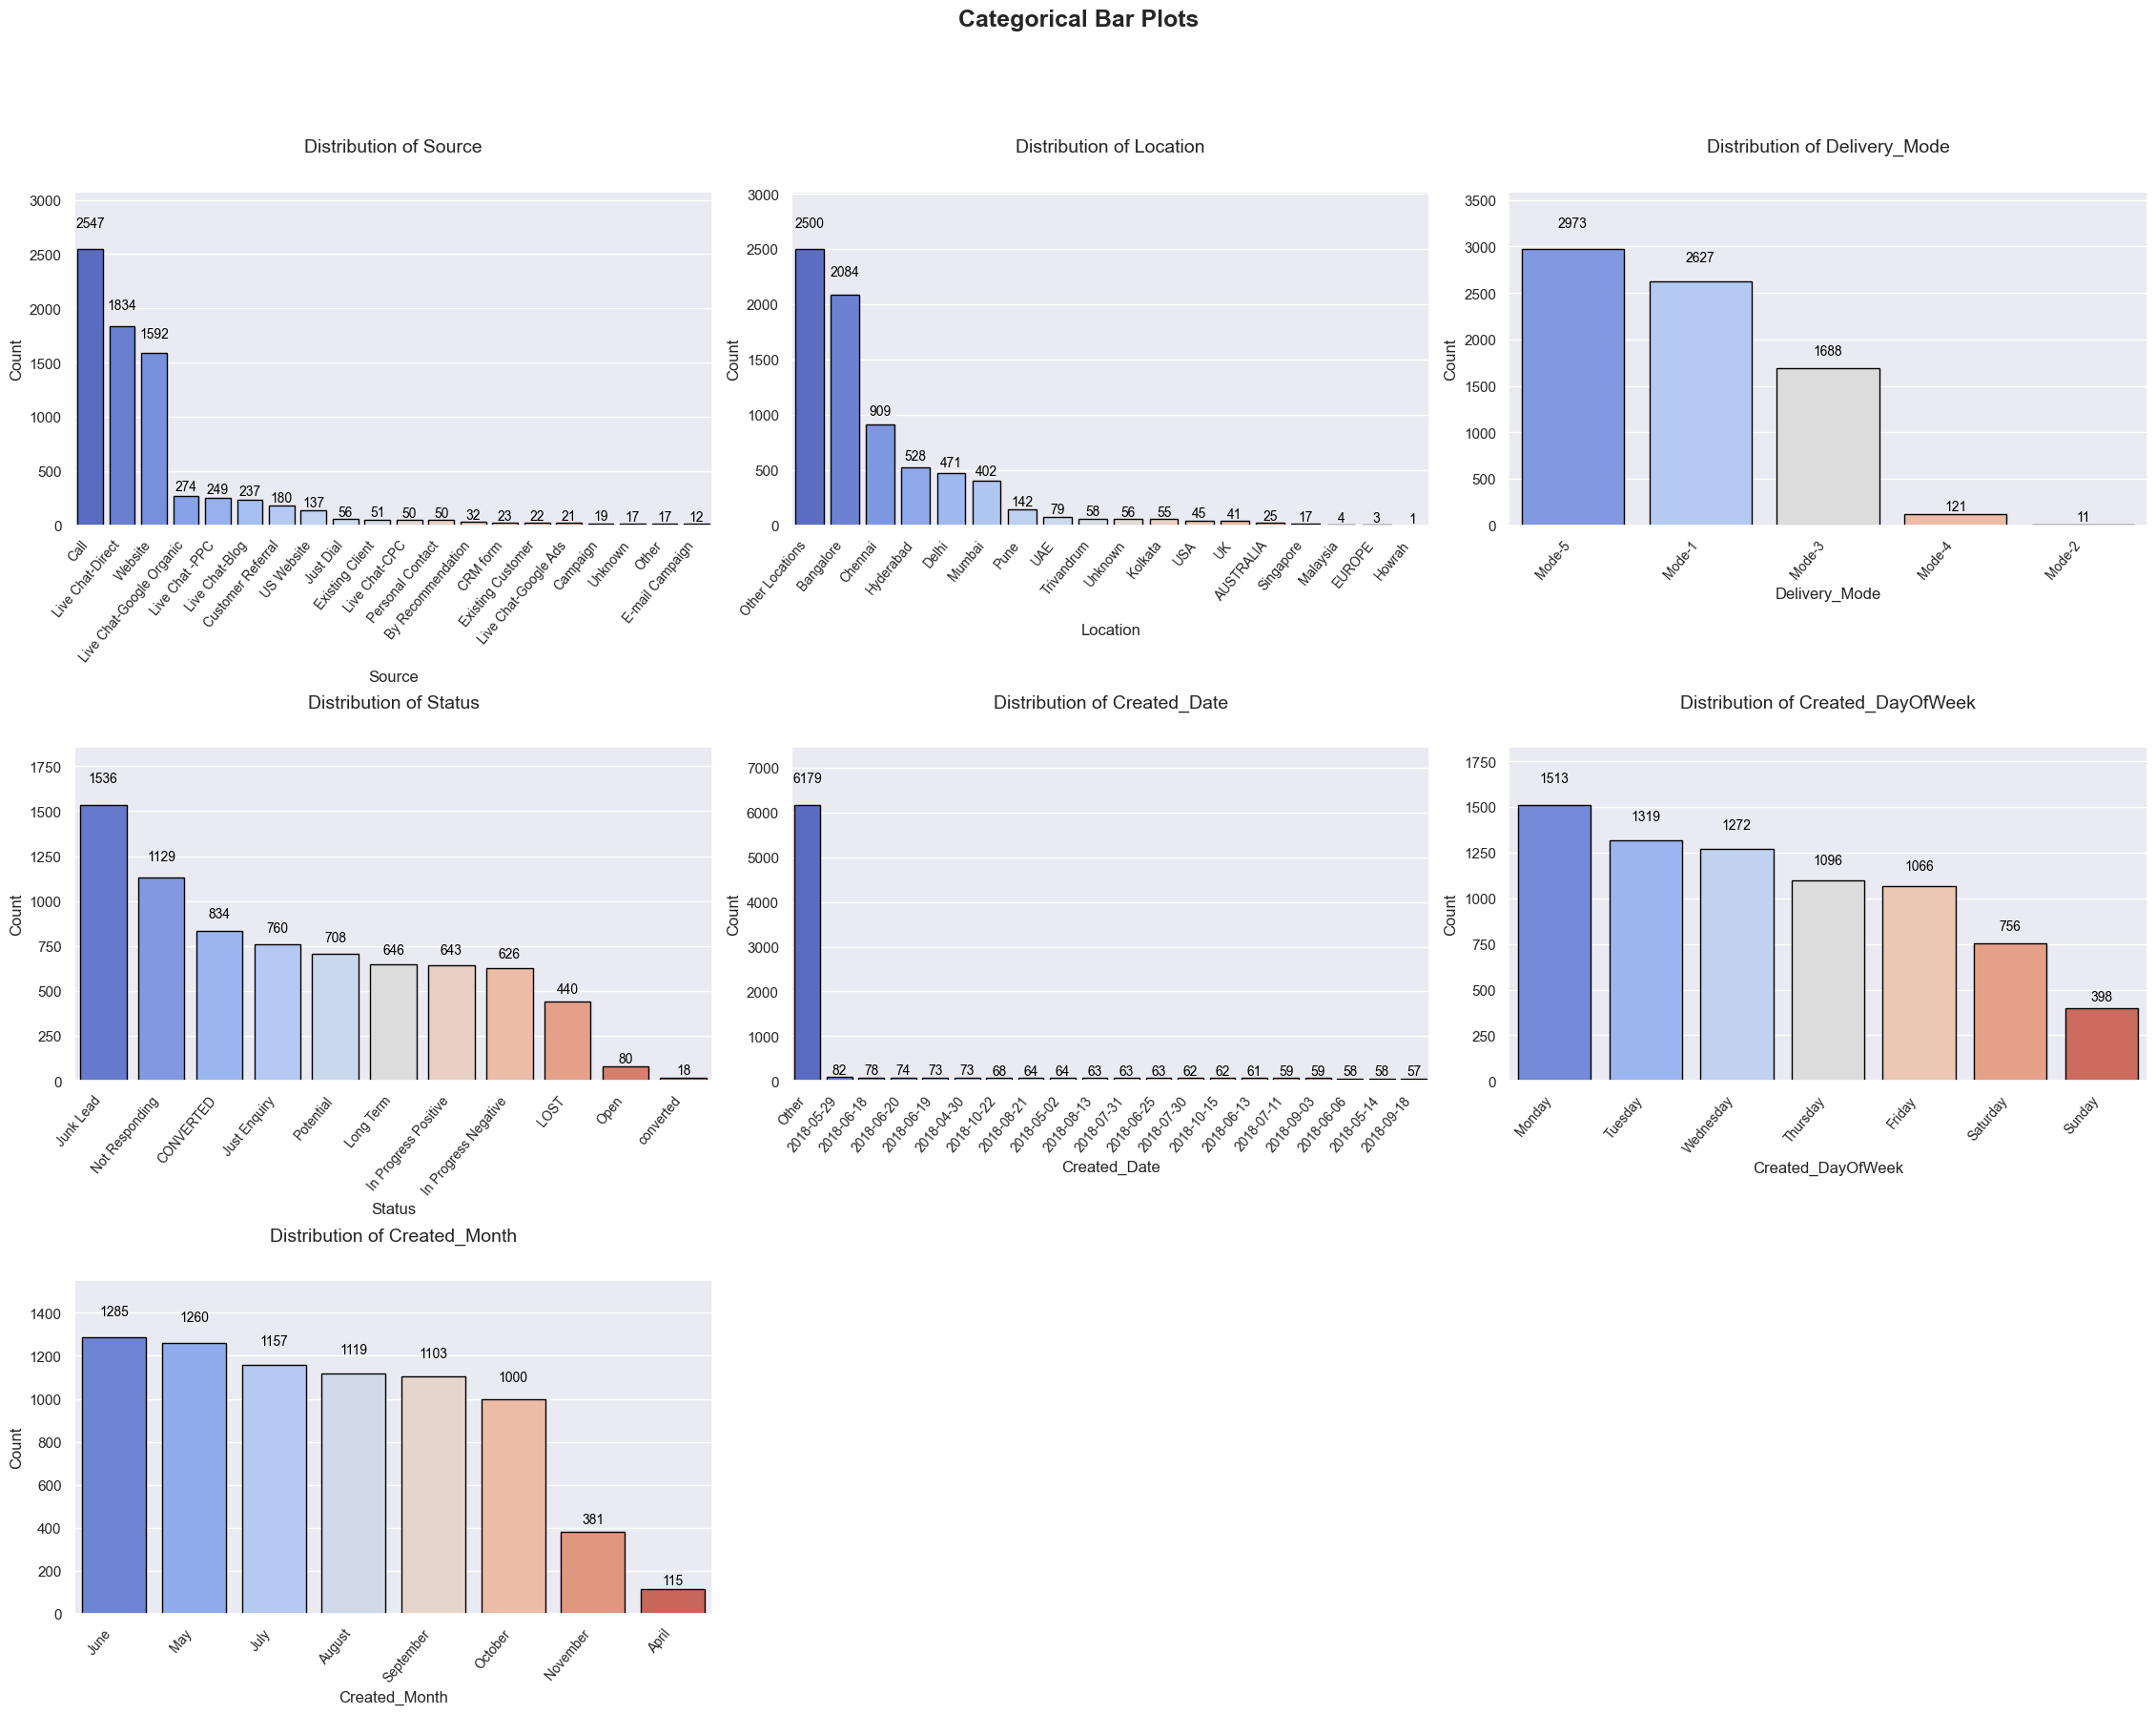


=== Excluded Columns ===
Time Series Columns (Auto-Detected): ['Created']
High Cardinality Columns (> 26 unique values): ['Created_Date']


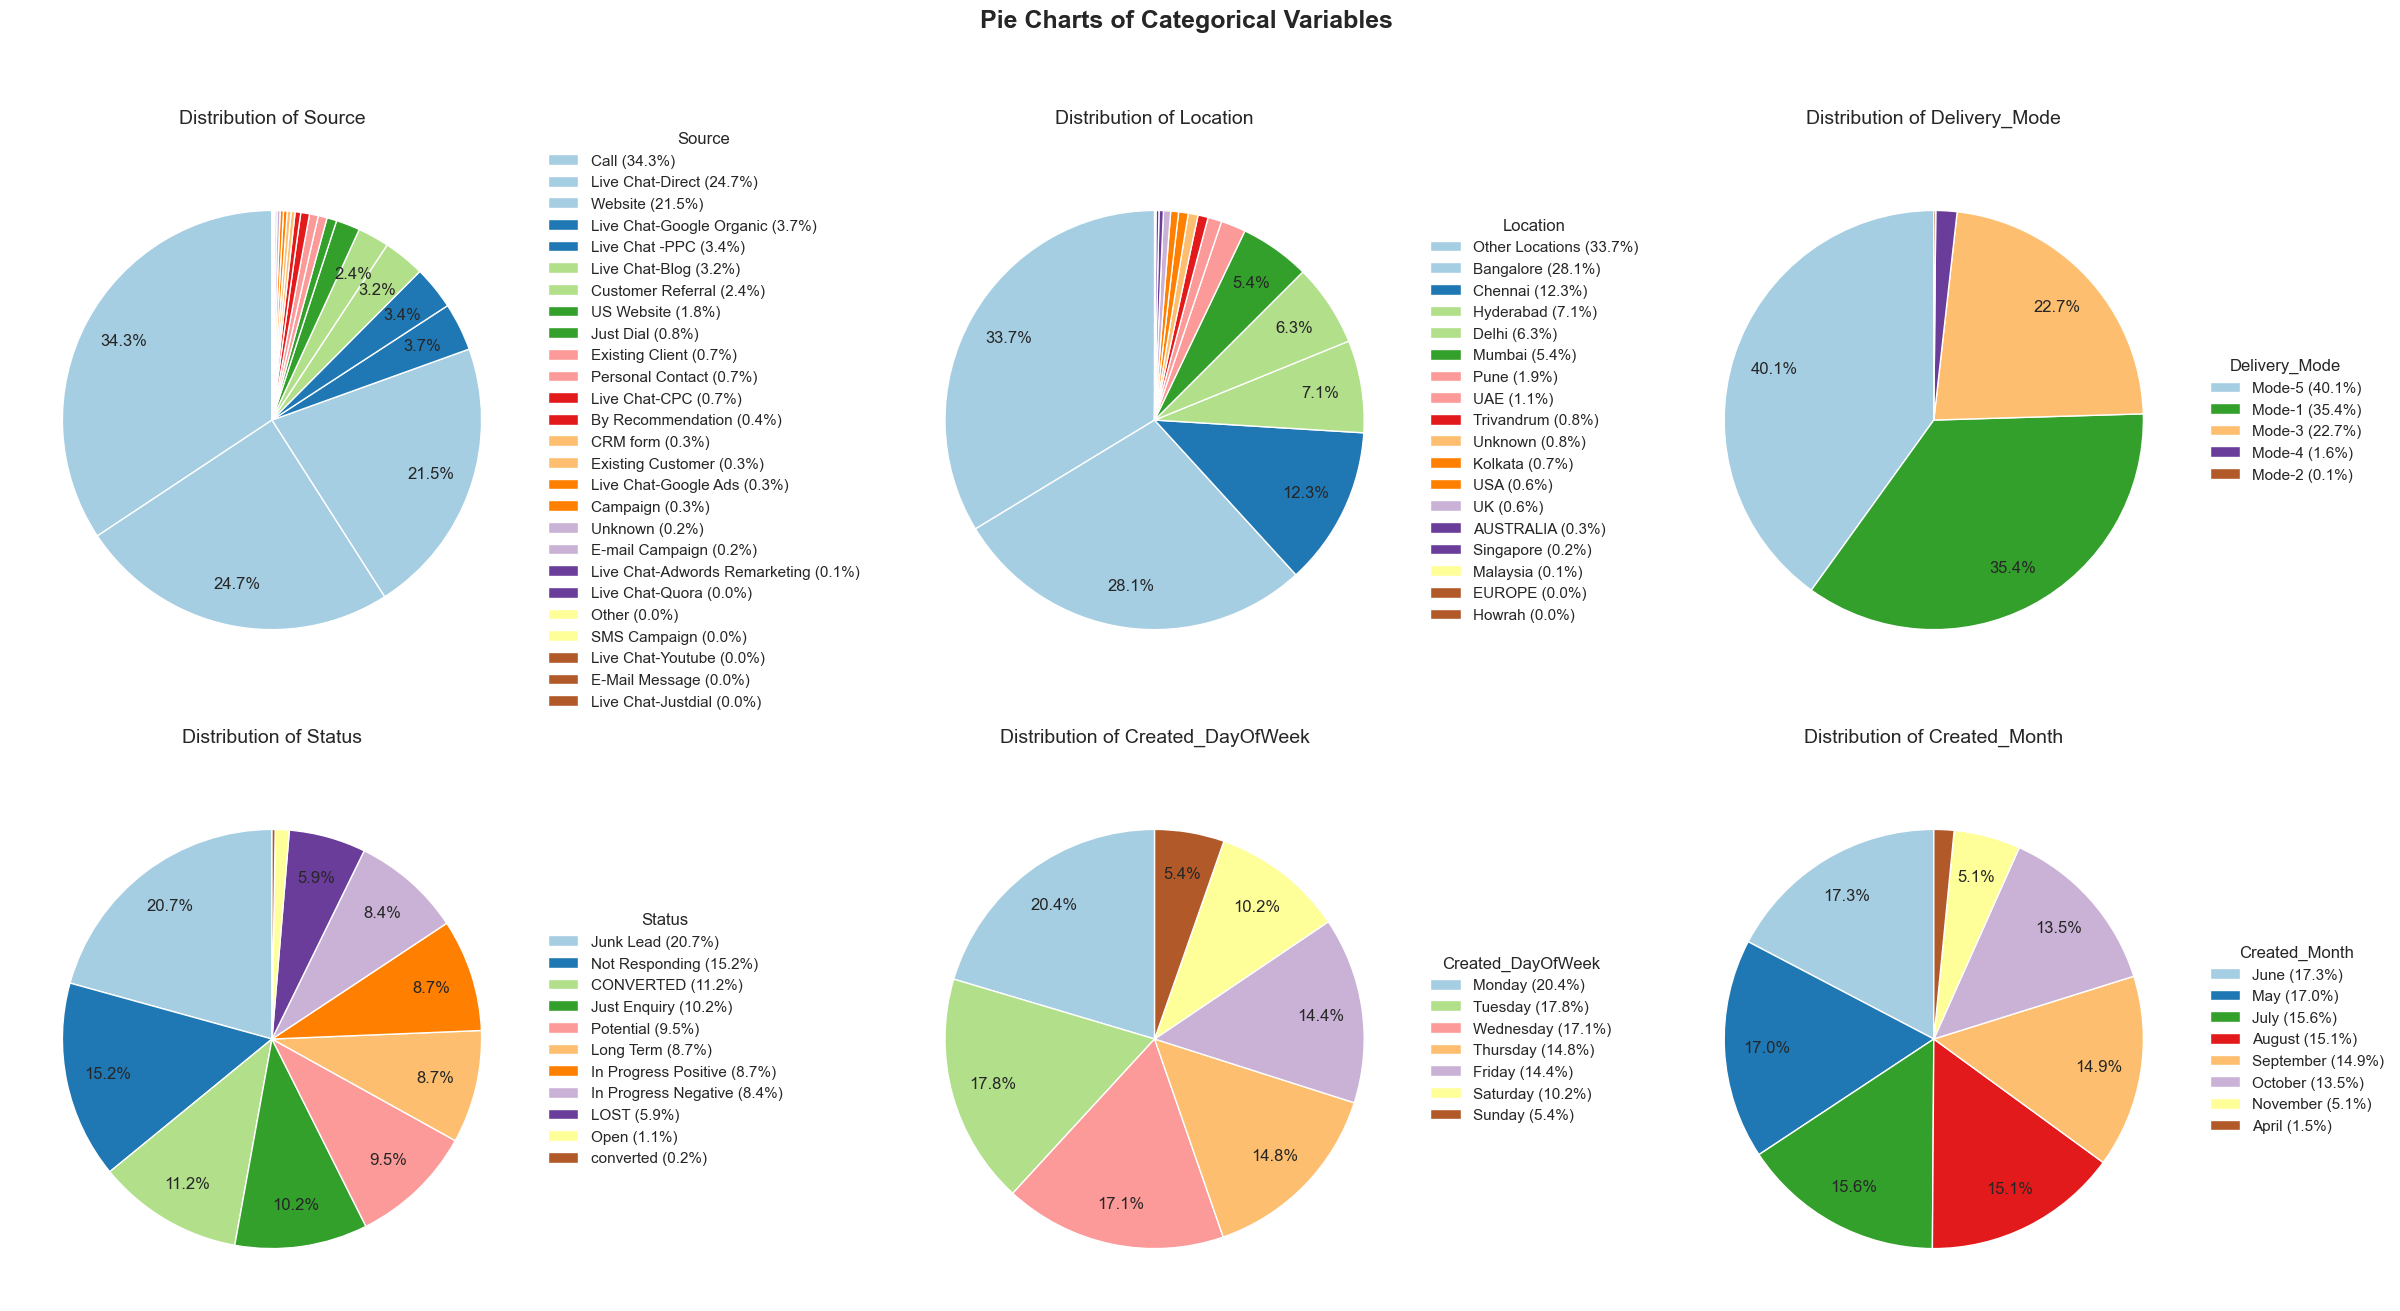

In [45]:
cat_bar_batches(data, batch_num=1)
cat_pie_chart_batches(data, batch_num=1, high_cardinality_limit=26)

The categorical variable distributions reveal key insights about the dataset. In the source distribution, 34.3% of the entries originate from calls, making it the most dominant source, followed by live chat direct at 24.7% and website inquiries at 21.5%, indicating that more than 80% of the records come from these three channels. The location distribution highlights that 33.7% of the entries are from other locations, followed by Bangalore at 28.1%, Chennai at 12.3%, and Hyderabad at 7.1%, suggesting that over 80% of the data originates from a few key locations.

The delivery mode distribution shows that 40.1% of transactions follow Mode-5, while Mode-1 and Mode-3 contribute 35.4% and 22.7%, respectively, indicating a strong preference for specific delivery processes. The status distribution highlights that 20.7% of leads are categorized as junk, while 15.2% are non-responsive, 11.2% have been converted, and 10.2% fall under just inquiry, suggesting that a significant portion of leads may not result in conversions.

Day-wise data distribution indicates that Monday has the highest number of records at 20.4%, followed by Tuesday at 17.8% and Wednesday at 17.1%, with the lowest on Sunday at 5.4%, suggesting that business activity significantly declines towards the weekend. The month-wise distribution shows that June leads with 17.3%, followed by May at 17.0%, July at 15.6%, and August at 15.1%, with the lowest activity in April at 1.5%, indicating a seasonal trend in engagement.

These distributions suggest that the dataset is dominated by a few key sources, locations, and delivery modes, with engagement peaking at the start of the week and during mid-year months. This highlights potential areas for process improvements, such as optimizing lead filtering and targeting marketing efforts during high-activity periods.

### Bivariate & Multivariate Analysis

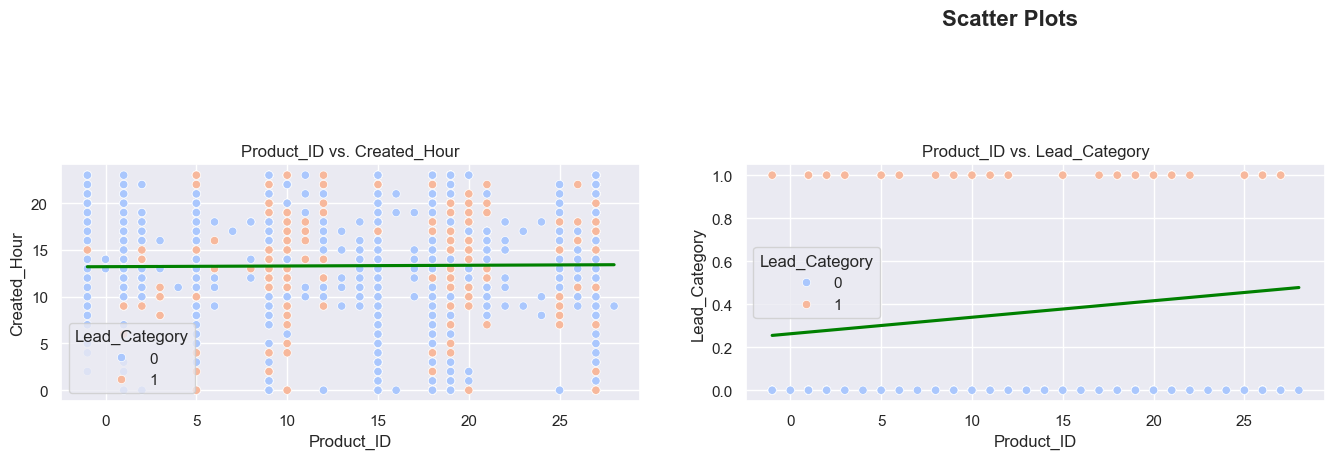

In [46]:
num_vs_num_scatterplot_pair_batch(data, pair_num=0, batch_num=1, hue_column="Lead_Category")

In the Product_ID vs. Created_Hour plot, the distribution of points is widespread across different hours, indicating that product registrations or activity occur throughout the day. However, the regression line remains almost flat, suggesting no strong correlation between the product ID and the time of creation. The points are fairly evenly spread, with no clear clusters or trends linking specific product IDs to certain hours.

In the Product_ID vs. Lead_Category plot, lead categories are binary, represented as either 0 or 1. The distribution of points shows that both categories are present across different product IDs, but the regression line has a slight positive slope. This suggests a weak increasing trend where higher product IDs may have a slightly higher likelihood of being classified under lead category 1. However, the dispersion of points indicates that the lead category is not strongly dependent on product ID, and other factors likely play a more significant role in determining category assignment.


=== High Cardinality Columns (>26 unique values) ===
Created_Date: 201 unique values


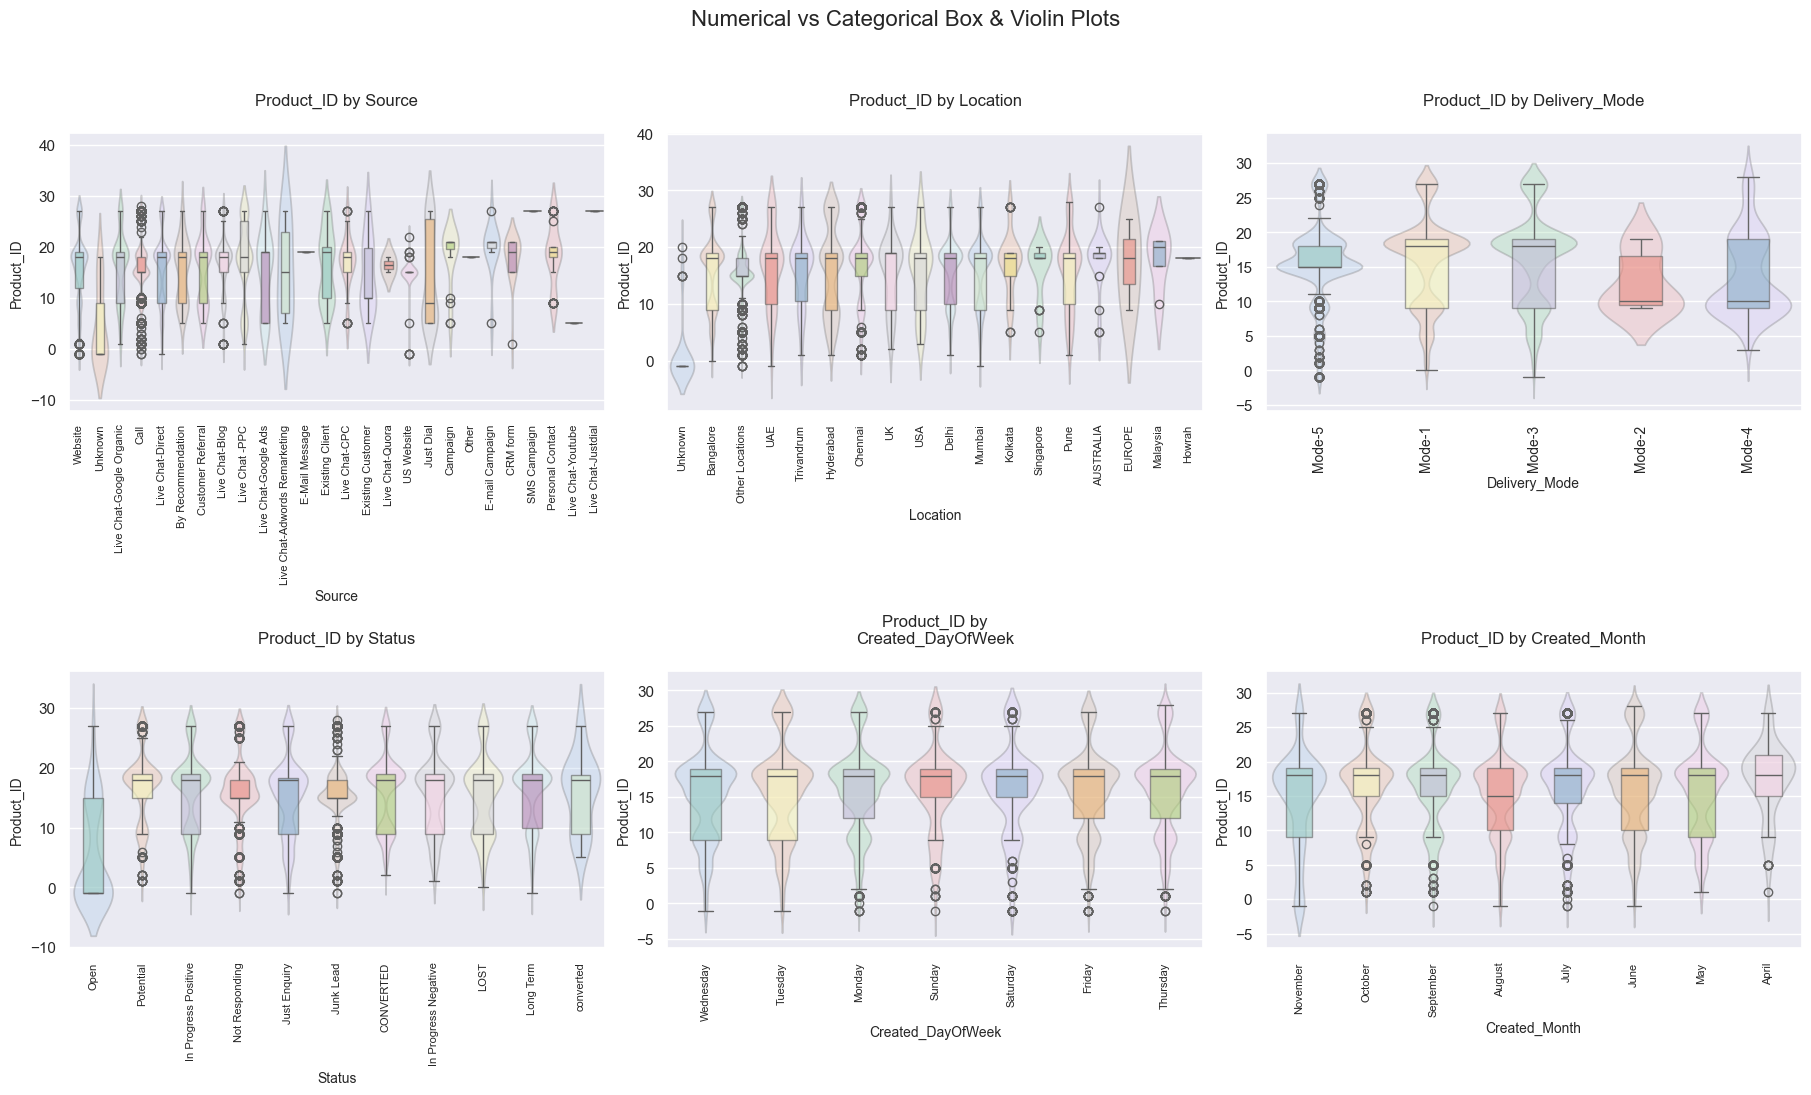

In [47]:
num_vs_cat_box_violin_pair_batch(data, pair_num=0, batch_num=1, high_cardinality_limit=26, show_high_cardinality=False)

The violin and box plots illustrate the distribution of Product_ID across various categorical variables. In the Product_ID by Source plot, different sources exhibit varying distributions, with some sources having a wider spread of Product_ID values, indicating a higher variance. Certain sources show concentrated distributions with outliers, suggesting that specific sources are associated with particular product ranges. The Product_ID by Location plot shows that locations have varied distributions, with some locations displaying more concentrated ranges, while others, like Bangalore and Other Locations, have a wider spread of Product_ID values.

The Product_ID by Delivery_Mode plot indicates that different delivery modes have distinct distributions, with some modes showing a broader range of product values. Mode-5 and Mode-1 exhibit more variability compared to other modes, which have relatively tighter distributions. The Product_ID by Status plot highlights that different lead statuses have varying product distributions, with some categories like "Junk Lead" and "Converted" having a broader spread, while others like "Long Term" and "Potential" are more concentrated.

The Product_ID by Created_DayOfWeek plot shows that product distributions remain relatively consistent across weekdays, with no significant deviations in central tendencies. However, some days exhibit a broader spread, indicating variability in product registrations. Similarly, in the Product_ID by Created_Month plot, the spread of Product_ID values remains fairly uniform across months, though some months like October and June exhibit slightly wider distributions, hinting at potential seasonal variations in product activity.


=== High Cardinality Columns (>26 unique values) ===
Created_Date: 201 unique values


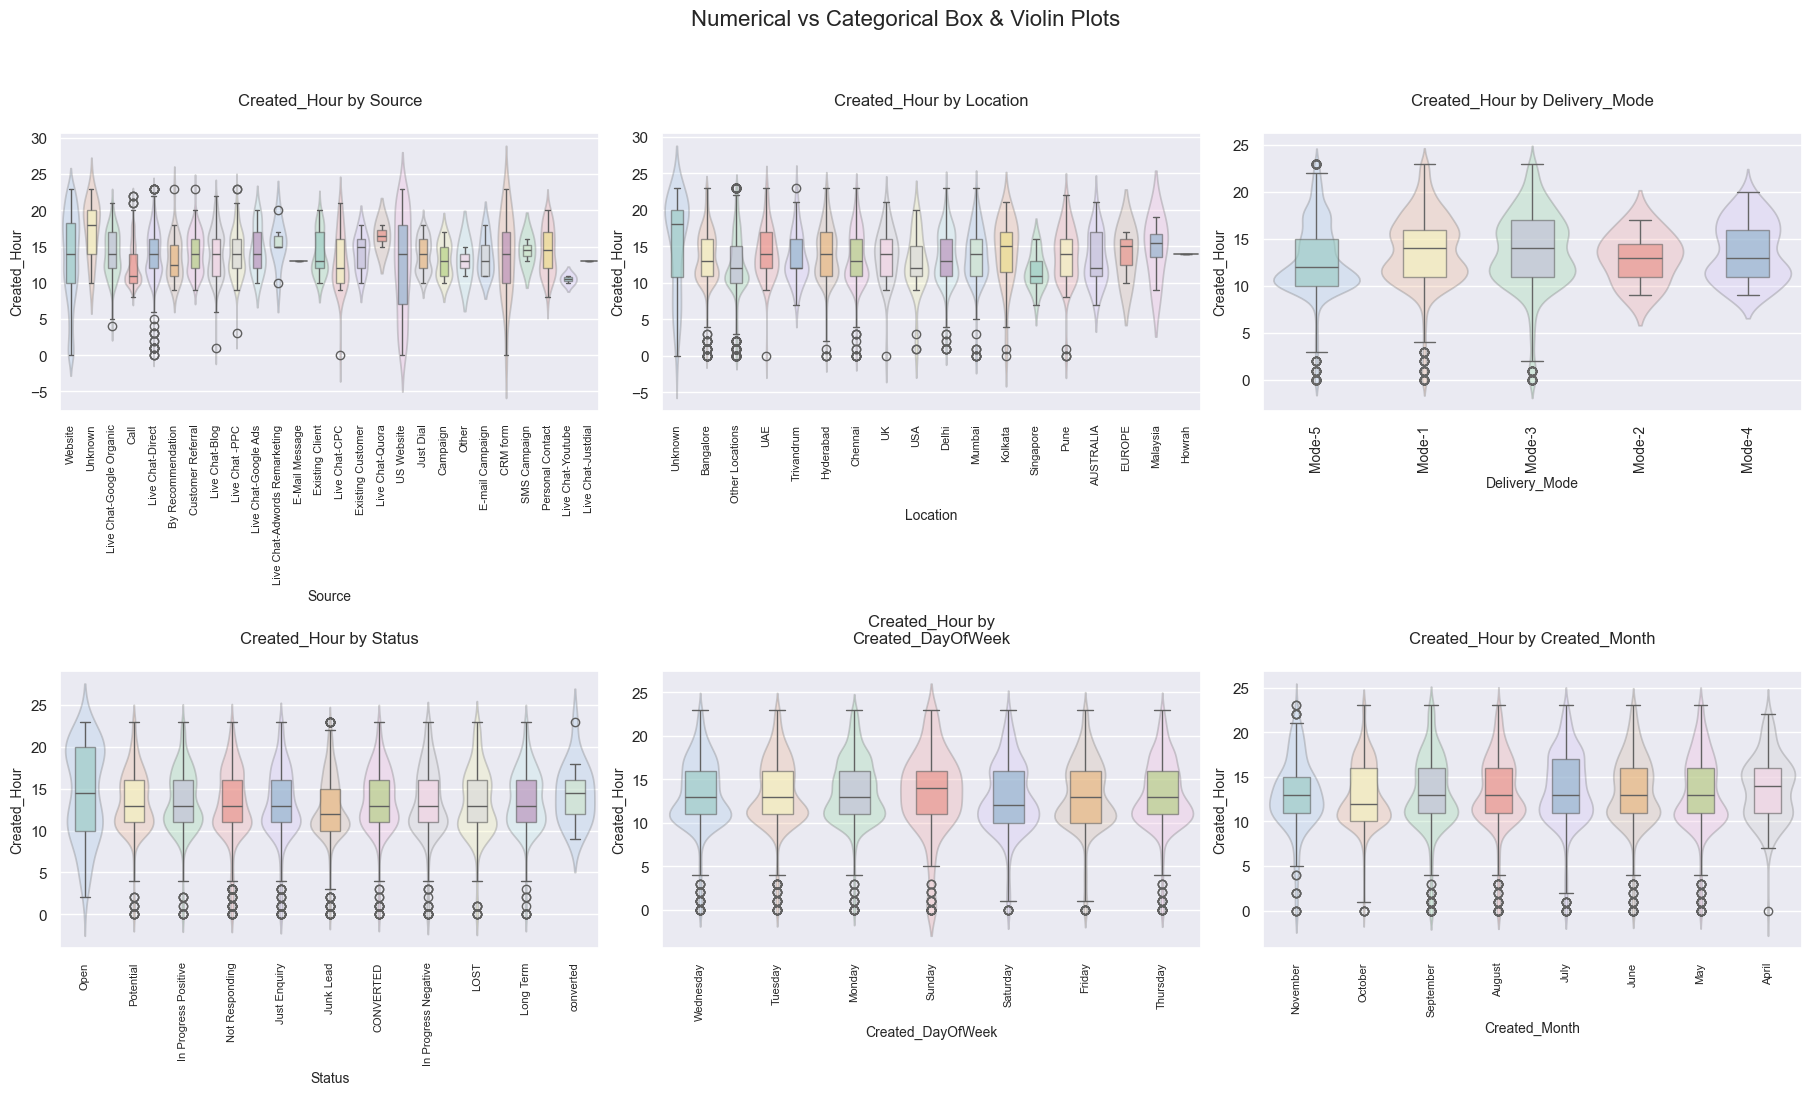

In [48]:
num_vs_cat_box_violin_pair_batch(data, pair_num=1, batch_num=1, high_cardinality_limit=26, show_high_cardinality=False)

The distribution of Created_Hour varies across different categories, reflecting patterns in data creation timing. Among the sources, Live Chat-Direct and Website show a broader spread, suggesting activity throughout the day, whereas sources like Live Chat-Justdial and E-Mail Message are more concentrated around specific hours. The distribution by location is relatively uniform, though Bangalore and Other Locations exhibit a slightly wider spread, indicating more diverse time ranges for data entries.

In Delivery Mode, Mode-1 and Mode-3 have more evenly distributed creation hours, while Mode-5 has a higher density around late morning and afternoon. The variation in lead status suggests that Junk Leads and Not Responding entries span a wider range of hours, while Converted and Potential leads have a more condensed distribution, indicating structured follow-ups. The hourly trend across days of the week remains fairly stable, though Tuesday and Wednesday exhibit slightly broader spreads, implying higher fluctuations in entry times. In monthly trends, the distributions remain similar, but October and September show slightly more variance, possibly due to seasonal effects.


=== High Cardinality Columns (>26 unique values) ===
Created_Date: 201 unique values


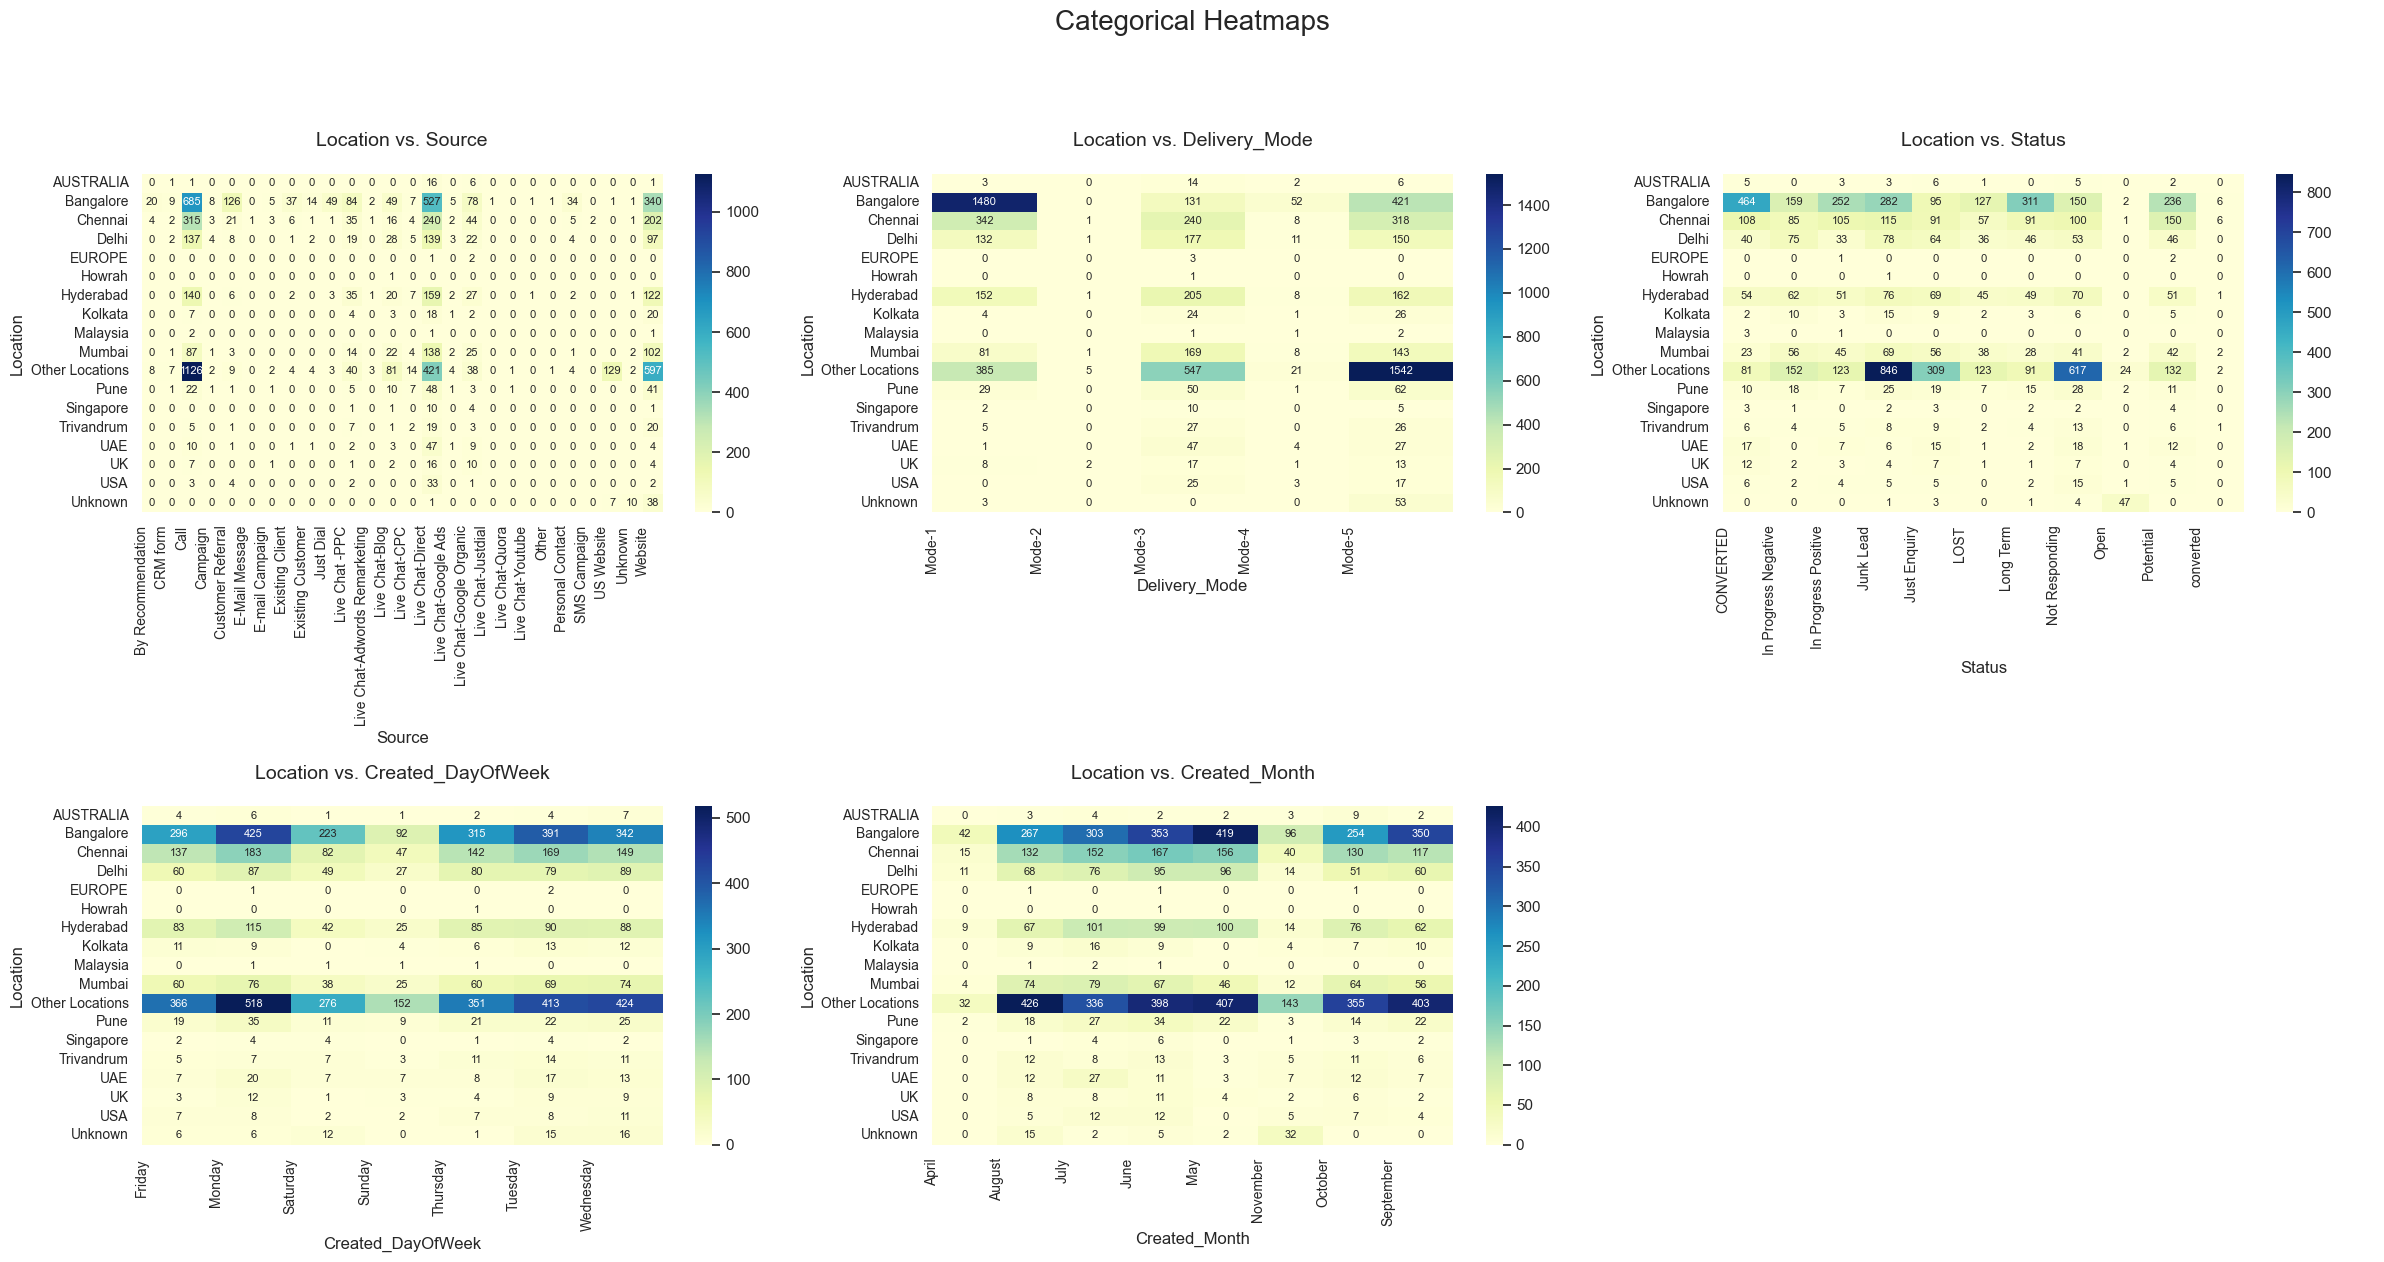

In [49]:
cat_vs_cat_pair_batch(data, pair_num=1, batch_num=1,high_cardinality_limit=26, show_high_cardinality=False)

The Location vs. Source heatmap indicates that Bangalore, Other Locations, and Chennai contribute the most data entries, with Call (34.3%), Live Chat-Direct (24.7%), and Website (21.5%) being the most common sources. In contrast, locations such as Australia, USA, and UAE show minimal engagement, suggesting lower interaction from these regions. The Location vs. Delivery Mode heatmap reveals a strong preference for Mode-5 (40.1%) and Mode-1 (35.4%) across all locations, especially in Bangalore and Other Locations, while Mode-2 (0.1%) and Mode-4 (1.6%) are rarely used, indicating limited adoption. The Location vs. Status heatmap highlights that Junk Leads (20.7%) and Not Responding (15.2%) dominate across regions, particularly in Other Locations, Bangalore, and Chennai, while Converted leads (11.2%) remain relatively low across all locations, with slightly better conversion rates observed in Mumbai and Pune. The Location vs. Created Day of the Week heatmap shows a trend where most data entries occur on Monday (20.4%) and Tuesday (17.8%), particularly in Bangalore and Other Locations, whereas Sunday (5.4%) records the lowest activity, implying reduced engagement on weekends. The Location vs. Created Month heatmap illustrates that June (17.3%), May (17.0%), and July (15.6%) are the most active months for data creation, predominantly in Bangalore and Other Locations, while November (5.1%) and April (1.5%) exhibit lower engagement, suggesting seasonal variations in activity.

----

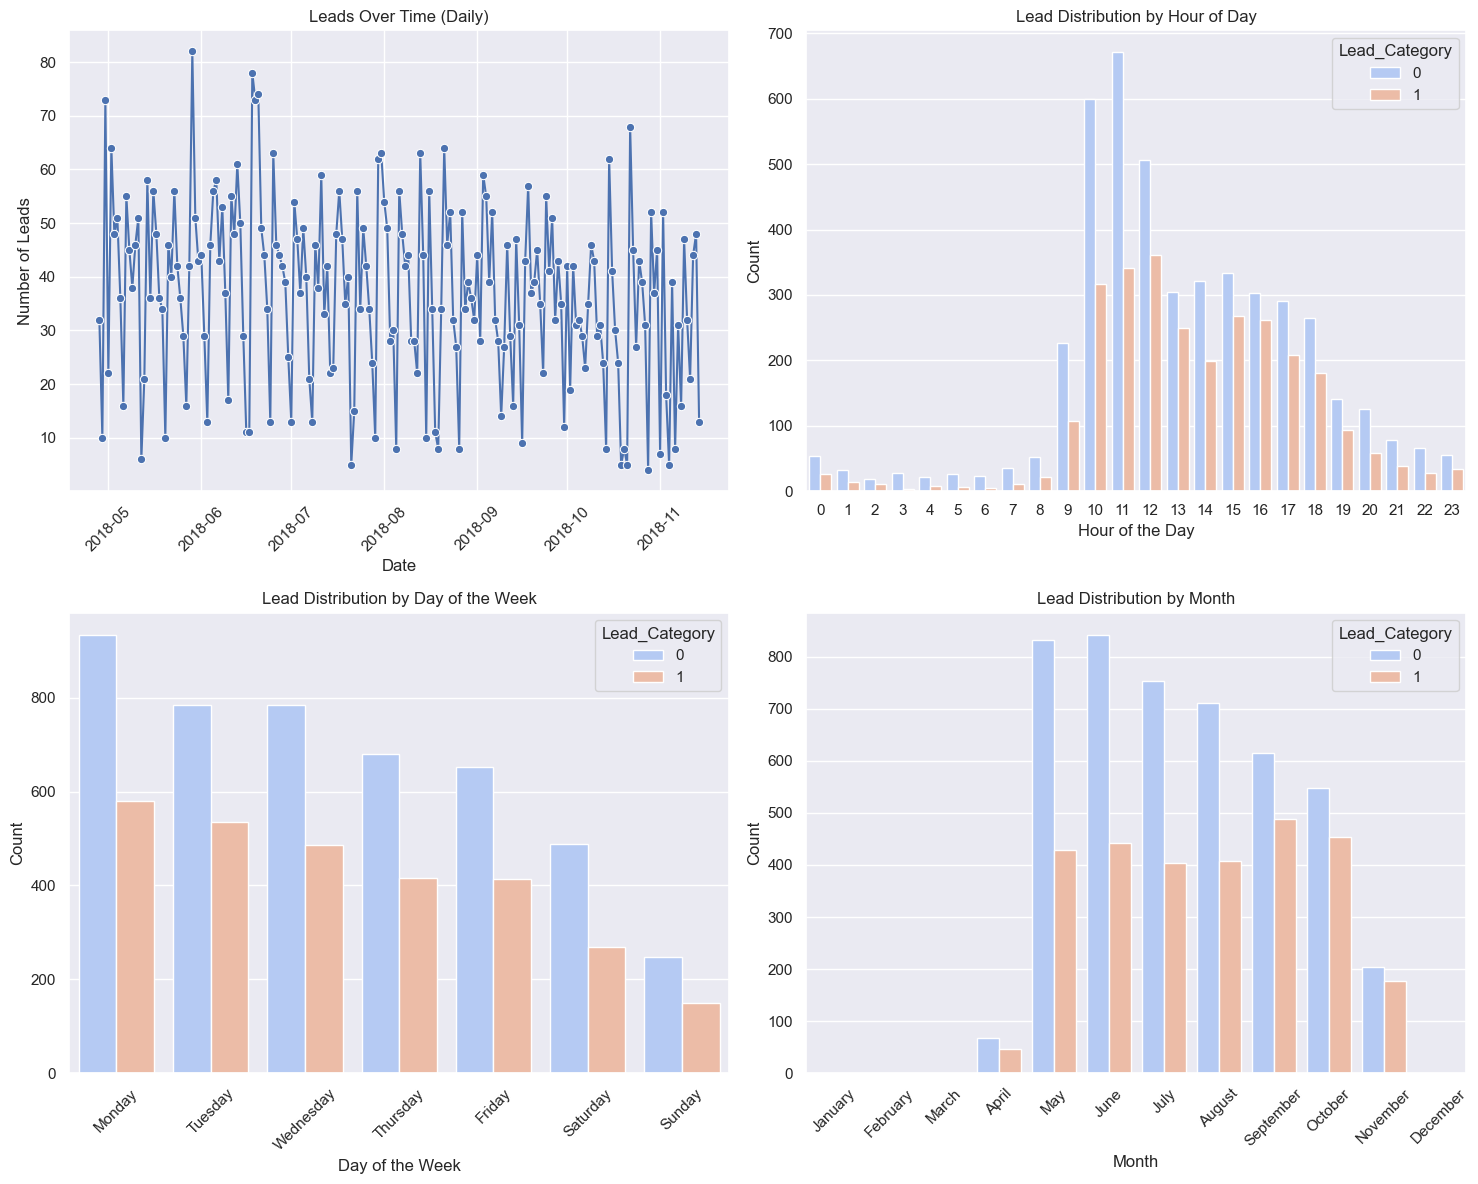

In [50]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
daily_counts = data.groupby("Created_Date")["Lead_Category"].count()
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker="o")
plt.xticks(rotation=45)
plt.title("Leads Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Number of Leads")
plt.subplot(2, 2, 2)
sns.countplot(x="Created_Hour", hue="Lead_Category", data=data, palette="coolwarm")
plt.title("Lead Distribution by Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.subplot(2, 2, 3)
sns.countplot(x="Created_DayOfWeek", hue="Lead_Category", data=data, order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Lead Distribution by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.subplot(2, 2, 4)
sns.countplot(x="Created_Month", hue="Lead_Category", data=data, palette="coolwarm", order=[
    "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
plt.xticks(rotation=45)
plt.title("Lead Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The Leads Over Time (Daily) trend shows fluctuations in lead generation, with higher activity observed in May and June before gradually declining towards November. Peaks in lead generation indicate specific days with increased activity, suggesting periodic surges in engagement. The Lead Distribution by Hour of the Day highlights a strong concentration of leads between 10 AM and 2 PM, with a sharp peak at 11 AM, indicating that most leads are generated during late morning and early afternoon, while early morning and late evening hours contribute minimally. The Lead Distribution by Day of the Week confirms that Monday records the highest number of leads, followed by Tuesday and Wednesday, while weekends, especially Sunday, experience the lowest lead activity, indicating reduced engagement during off-work days. The Lead Distribution by Month reinforces that May, June, and July are the most active months for lead generation, while October and November see a notable decline, suggesting possible seasonal effects or business trends influencing engagement.

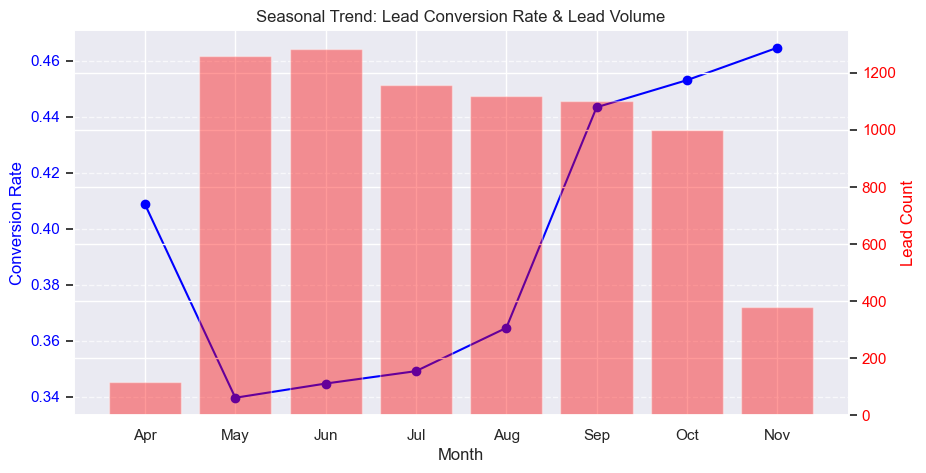

In [51]:
data["Created_Month"] = data["Created"].dt.month
monthly_counts = data["Created_Month"].value_counts().sort_index()
monthly_trend = data.groupby("Created_Month")["Lead_Category"].mean()
all_months = pd.Series(index=range(1, 13), dtype=float)
monthly_trend = all_months.combine_first(monthly_trend)
monthly_counts = all_months.combine_first(monthly_counts)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(monthly_trend.index, monthly_trend.values, marker='o', linestyle='-', color='blue', label="Conversion Rate")
ax1.set_ylabel("Conversion Rate", color="blue")
ax1.set_xlabel("Month")
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax1.tick_params(axis="y", labelcolor="blue")
ax2 = ax1.twinx()
ax2.bar(monthly_counts.index, monthly_counts.values, alpha=0.4, color='red', label="Lead Count")
ax2.set_ylabel("Lead Count", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.title("Seasonal Trend: Lead Conversion Rate & Lead Volume")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The seasonal trend in lead conversion rate and lead volume indicates a fluctuating relationship between the two. In April, the conversion rate is relatively high at around 40%, but the lead volume remains low. May and June see a significant rise in lead count, peaking above 1200, while the conversion rate drops sharply to around 34%, suggesting that although more leads were generated, their quality or engagement may have been lower. From July to August, both metrics remain relatively stable, but starting in September, the conversion rate begins to rise sharply, surpassing 46% in November, despite a decrease in lead volume. This suggests that fewer but higher-quality leads were converted in later months, possibly due to better targeting, refined marketing strategies, or seasonal demand shifts.

# Predictive Model

## Preprocessing

In [52]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     0          Created                        datetime64[ns]  N/A                            6752
2     1          Product_ID                     int32           -1 - 28                        30
3     7          Created_Hour                   int32           0 - 23                         24
4     9          Created_Month                  int32           4 - 11                         8
5     10         Lead_Category                  int64           0 - 1                          2
6     2          Source                         object          N/A                            26
7     3          Location                       object          N/A                            18
8     4          Delivery_Mode                  obje

#### outliers

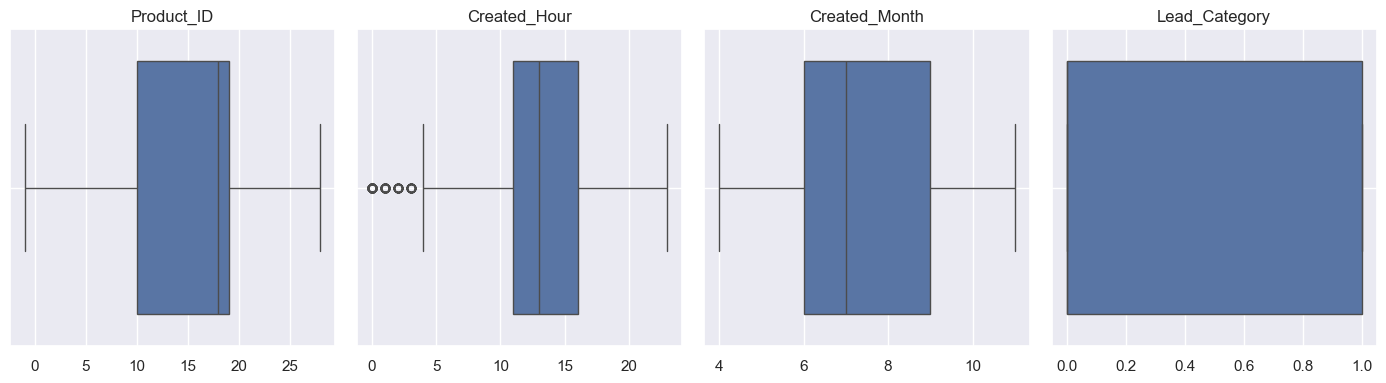

,Skewness,Kurtosis
Product_ID,-0.278313,-0.019361
Created_Hour,-0.256380,0.936378
Created_Month,0.139406,-1.100203
Lead_Category,0.477275,-1.772686


In [53]:
plot_boxplots(data)
calculate_skewness_kurtosis(data)

In [54]:
detect_outliers(data)

,Column,Q1,Q3,IQR,Lower Bound,Upper Bound,Total Distinct,Outliers Distinct,Outliers Count,Outliers %,Outliers (First 10)
0,Created_Hour,11.0,16.0,5.0,3.5,23.5,24,4,185,2.49%,"0, 1, 2, 3"


 the upper bound aligns with the natural limit of 23, while the lower bound highlights potential outliers below 3.5. There are 24 distinct values in this column, with 4 distinct outliers comprising 185 occurrences, making up 2.49% of the dataset. The first detected outliers are hours 0, 1, 2, and 3, indicating that activity during these early hours is significantly less frequent compared to the central range.

#### relation


Normal Columns (p > 0.05):


,Column,Test,Statistic,p_value,Skewness,Kurtosis



Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


,Column,Test,Statistic,p_value,Skewness,Kurtosis
1,Created_Hour,Kolmogorov-Smirnov,0.107831,1.374900e-75,-0.256328,0.934939
2,Created_Month,Kolmogorov-Smirnov,0.146137,9.181527e-139,0.139378,-1.100270
0,Product_ID,Kolmogorov-Smirnov,0.184837,2.303003e-222,-0.278257,-0.020157
3,Lead_Category,Kolmogorov-Smirnov,0.401106,0.000000e+00,0.477179,-1.772300



Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
No multicollinear pairs found.


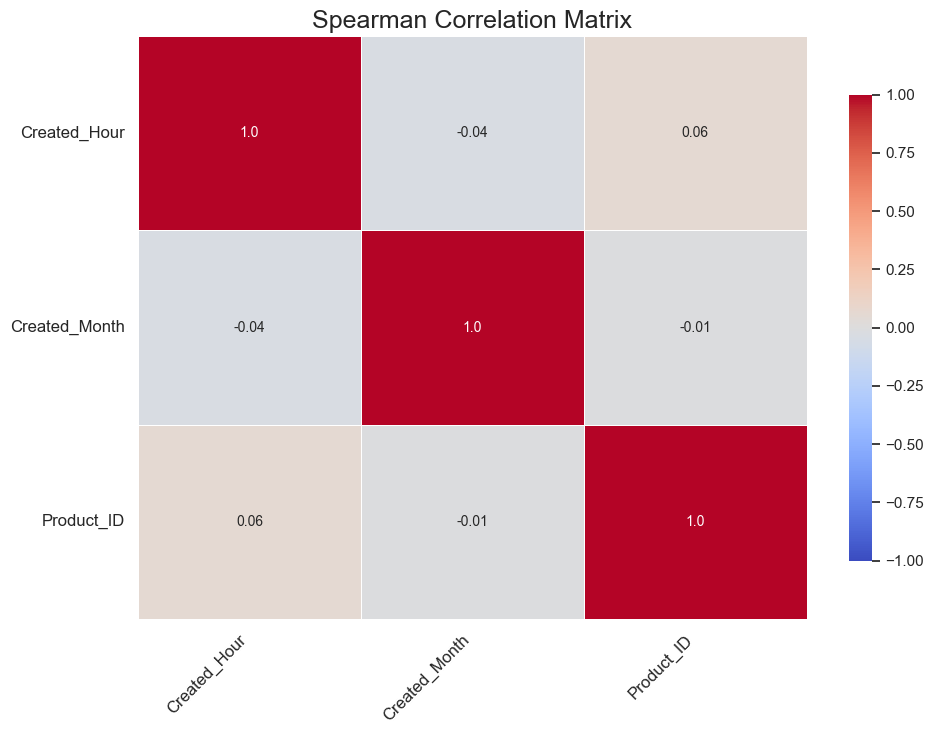

In [55]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)
spearman_correlation(data, data_not_normal_df, exclude_target="Lead_Category", multicollinearity_threshold=0.8)

In [56]:
at_above, at_below =calculate_vif(data, exclude_target='Lead_Category', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
      Feature      VIF
Created_Month 8.676775

Features with VIF <= threshold (Low/No Multicollinearity):
     Feature      VIF
Created_Hour 7.908890
  Product_ID 6.088943


The Spearman correlation matrix indicates weak correlations among the variables, with Created_Hour and Product_ID showing a slight positive correlation of 0.06, while Created_Month has a near-zero correlation with both variables. This suggests that the time of lead creation and product selection are largely independent of each other. The Variance Inflation Factor (VIF) analysis reveals Created_Month exceeding the multicollinearity threshold of 8.0, indicating strong redundancy with other variables. Meanwhile, Created_Hour has a VIF slightly below the threshold at 7.91, and Product_ID remains within an acceptable range at 6.09. for clssification it's ok 

#### Association

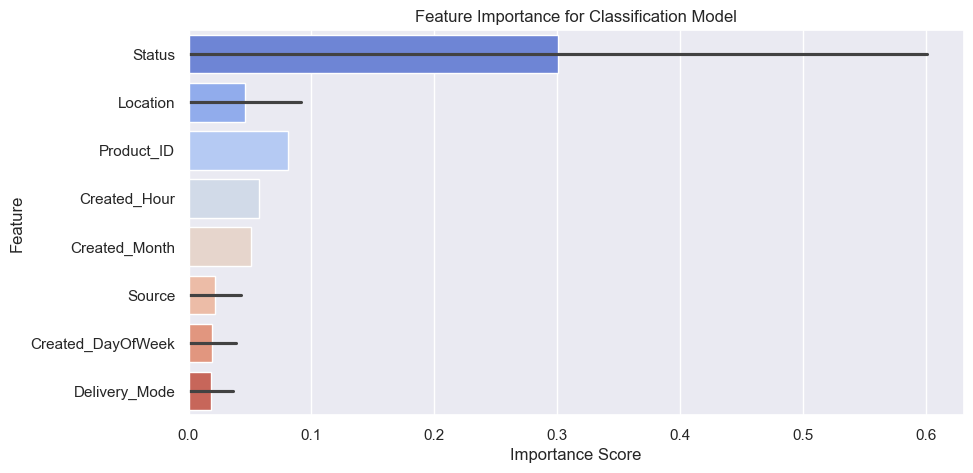

             Feature  MI Score  Importance
6             Status  0.000000    0.600780
4           Location  0.000000    0.091334
0         Product_ID  0.000000    0.081174
1       Created_Hour  0.000000    0.057757
2      Created_Month  0.000000    0.050777
3             Source  0.000000    0.043065
7  Created_DayOfWeek  0.000000    0.038511
5      Delivery_Mode  0.000000    0.036603
0             Source  0.035705    0.000000
1           Location  0.074204    0.000000
2      Delivery_Mode  0.031180    0.000000
3             Status  0.665971    0.000000
4  Created_DayOfWeek  0.000383    0.000000


In [57]:
data_copy = data.copy()
categorical_cols = ["Source", "Location", "Delivery_Mode", "Status", "Created_DayOfWeek"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_copy[col] = le.fit_transform(data_copy[col])
    label_encoders[col] = le  # Save encoder for future use
numerical_cols = ["Product_ID", "Created_Hour", "Created_Month"]
categorical_cols = ["Source", "Location", "Delivery_Mode", "Status", "Created_DayOfWeek"]
mi_scores = mutual_info_classif(data_copy[categorical_cols], data_copy["Lead_Category"], discrete_features=True)
mi_df = pd.DataFrame({"Feature": categorical_cols, "MI Score": mi_scores})
X = data_copy[numerical_cols + categorical_cols]
y = data_copy["Lead_Category"]
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": model.feature_importances_})
combined_df = pd.concat([mi_df, feature_importances], axis=0).fillna(0)
combined_df = combined_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(y=combined_df["Feature"], x=combined_df["Importance"], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Classification Model")
plt.show()
print(combined_df)

#### Encoding

In [58]:
columns_to_remove = ["Created", "Created_Date", "Status", "Created_DayOfWeek", "Created_Hour"]
data.drop(columns=columns_to_remove, inplace=True)

In [59]:
frequency_encoded_cols = ["Source", "Location"]
for col in frequency_encoded_cols:
    data[col + "_freq"] = data[col].map(data[col].value_counts())  
data.drop(columns=frequency_encoded_cols, inplace=True)
one_hot_encoded_cols = ["Delivery_Mode"]
data = pd.get_dummies(data, columns=one_hot_encoded_cols, drop_first=True)  

In [60]:
data["Lead_Category"] = data["Lead_Category"].astype("int8") 
data["Source_freq"] = data["Source_freq"].astype("int32") 
data["Location_freq"] = data["Location_freq"].astype("int32") 

The feature importance analysis highlights that Status is the most influential variable in the classification model, contributing significantly with an importance score of 0.60, far exceeding other features. Location follows at 0.09, while Product_ID holds a moderate impact at 0.08. Other features such as Created_Hour, Created_Month, Source, Created_DayOfWeek, and Delivery_Mode exhibit relatively lower importance, all scoring below 0.06, suggesting minimal impact on the model’s predictions. The mutual information (MI) scores indicate that Status has the highest dependency with the target variable, reinforcing its dominance in determining outcomes. Encoding transformations involve frequency encoding for Source and Location, along with one-hot encoding for Delivery_Mode, while redundant columns such as Created, Created_Date, Status, Created_DayOfWeek, and Created_Hour are removed to optimize model performance. 

#### Splitting 

In [61]:
X = data.drop(columns='Lead_Category')
y = data['Lead_Category']

In [62]:
print("Class distribution:")
print(y.value_counts())

Class distribution:
Lead_Category
0    4571
1    2849
Name: count, dtype: int64


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5936, 8) (1484, 8) (5936,) (1484,)


In [64]:
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict

{0: 0.8115942028985508, 1: 1.302325581395349}

The dataset is imbalanced, with Lead_Category 0 having 4571 instances and Lead_Category 1 having 2849, making up approximately 61.6% and 38.4%, respectively. The dataset was split into training (80%) and testing (20%) sets, resulting in 5936 training samples and 1484 testing samples, each containing 8 features. To address class imbalance, class weights were computed using the balanced strategy, assigning a weight of 0.81 to the majority class (0) and 1.30 to the minority class (1). These weights help mitigate bias in classification models by penalizing misclassification of the minority class more heavily, ensuring better model generalization.

## Model Development

In [65]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model with additional metrics."""
    start_time = time.time()
    model.fit(X_train, y_train)  # Train the model
    train_time = time.time() - start_time  
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        log_loss_score = log_loss(y_test, y_proba)
        brier_score = brier_score_loss(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        log_loss_score, brier_score, roc_auc = None, None, None  
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=1)
    rec = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring='f1').mean()
    overfit = acc_train - acc
    return {
        "Training Time (seconds)": round(train_time, 3),
        "Accuracy": acc,
        "Balanced Accuracy": balanced_acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1_metric,
        "MCC (Matthews Correlation Coefficient)": mcc,
        "Cohen's Kappa": kappa,
        "ROC AUC Score": roc_auc,
        "Log Loss": log_loss_score,
        "Brier Score": brier_score,
        "Cross-Validation F1-Score": cv_f1,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Positives (TP)": tp,
        "Training Accuracy": acc_train,
        "Overfit (Train - Test Acc)": overfit
    }

def threshold_analysis(model, X_test, y_test, thresholds=np.arange(0.1, 1.0, 0.1)):
    y_probs = model.predict_proba(X_test)[:, 1]  
    results = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        results.append({
            "Threshold": round(threshold, 2),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-Score": round(f1, 4),
            "Accuracy": round(accuracy, 4),
            "True Negatives (TN)": tn,
            "False Positives (FP)": fp,
            "False Negatives (FN)": fn,
            "True Positives (TP)": tp
        })
    df_results = pd.DataFrame(results)
    best_threshold = df_results.loc[df_results["F1-Score"].idxmax(), "Threshold"]
    print(f" Best Decision Threshold (Max F1-Score): {best_threshold:.2f}")
    return df_results, best_threshold
    
def cross_validation_analysis_table(model, X_train, y_train, cv_folds=5, scoring_metric="f1"):
    strat_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring=scoring_metric)
    cv_results_df = pd.DataFrame({
        "Fold": [f"Fold {i+1}" for i in range(cv_folds)],
        "F1-Score": scores
    })
    cv_results_df.loc["Mean"] = ["Mean", np.mean(scores)]
    cv_results_df.loc["Std"] = ["Standard Deviation", np.std(scores)]
    return cv_results_df

In [66]:
def plot_all_evaluation_metrics(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    y_pred_default = (y_probs >= 0.4).astype(int)
    cm = confusion_matrix(y_test, y_pred_default)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes[0, 0].plot(prob_pred, prob_true, marker="o", label="Calibration")
    axes[0, 0].plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
    axes[0, 0].set_title("Calibration Curve")
    axes[0, 0].set_xlabel("Predicted Probability")
    axes[0, 0].set_ylabel("Actual Probability")
    axes[0, 0].legend()
    axes[0, 0].grid()
    skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test), ax=axes[0, 1])
    axes[0, 1].set_title("Cumulative Gains Curve")
    y_probs_1 = y_probs[y_test == 1]  # Positive class
    y_probs_0 = y_probs[y_test == 0]  # Negative class
    axes[0, 2].hist(y_probs_1, bins=50, alpha=0.5, label="y=1")
    axes[0, 2].hist(y_probs_0, bins=50, alpha=0.5, label="y=0")
    axes[0, 2].set_title("Kolmogorov-Smirnov (KS) Statistic")
    axes[0, 2].set_xlabel("Predicted Probability")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].legend()
    axes[0, 2].grid()
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = np.linspace(0.6, 0.9, 10)
    val_scores = np.linspace(0.55, 0.85, 10)
    axes[1, 0].plot(train_sizes, train_scores, label="Train Score")
    axes[1, 0].plot(train_sizes, val_scores, label="Validation Score")
    axes[1, 0].set_title("Learning Curve (Simulated)")
    axes[1, 0].set_xlabel("Training Size")
    axes[1, 0].set_ylabel("Score")
    axes[1, 0].legend()
    axes[1, 0].grid()
    skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=axes[1, 1])
    axes[1, 1].set_title("Lift Curve")
    axes[1, 2].plot(thresholds, precision[:-1], "b--", label="Precision")
    axes[1, 2].plot(thresholds, recall[:-1], "r-", label="Recall")
    axes[1, 2].set_title("Precision-Recall Curve")
    axes[1, 2].set_xlabel("Threshold")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].legend()
    axes[1, 2].grid()
    axes[2, 0].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    axes[2, 0].plot([0, 1], [0, 1], linestyle="--", color="black")
    axes[2, 0].set_title("ROC Curve")
    axes[2, 0].set_xlabel("False Positive Rate")
    axes[2, 0].set_ylabel("True Positive Rate")
    axes[2, 0].legend()
    axes[2, 0].grid()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[2, 1], cmap="Blues")
    axes[2, 1].set_title("Confusion Matrix")
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp_norm.plot(ax=axes[2, 2], cmap="Blues")
    axes[2, 2].set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

### Model Training & Evaluation

In [67]:
base_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),  
    "XGBoost": XGBClassifier(scale_pos_weight=class_weight_dict[1], use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=42),
    "CatBoost": CatBoostClassifier(auto_class_weights="Balanced", verbose=0, random_state=42)  
}

In [68]:
model_results = {}
for model_name, model in base_models.items():
    print(f"Training & Evaluating: {model_name}...")
    results = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_results[model_name] = results  
df_results = pd.DataFrame.from_dict(model_results, orient='index')
base_results = df_results.sort_values(by="Recall", ascending=False)

Training & Evaluating: Logistic Regression...
Training & Evaluating: Random Forest...
Training & Evaluating: Decision Tree...
Training & Evaluating: SVM...
Training & Evaluating: XGBoost...
Training & Evaluating: LightGBM...
[LightGBM] [Info] Number of positive: 2279, number of negative: 3657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 5936, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1823, number of negative: 2925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the over

In [69]:
base_results

,Training Time (seconds),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC (Matthews Correlation Coefficient),Cohen's Kappa,ROC AUC Score,Log Loss,Brier Score,Cross-Validation F1-Score,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP),Training Accuracy,Overfit (Train - Test Acc)
CatBoost,4.974,0.707547,0.718673,0.592141,0.766667,0.668196,0.425439,0.414363,0.805200,0.529458,0.180344,0.640667,613,301,133,437,0.739387,0.031840
LightGBM,0.245,0.696092,0.707062,0.580297,0.754386,0.655988,0.402844,0.391993,0.796565,0.537197,0.183511,0.631623,603,311,140,430,0.748821,0.052729
Logistic Regression,0.212,0.637466,0.644282,0.521739,0.673684,0.588055,0.280713,0.273571,0.695336,0.635564,0.222166,0.565846,562,352,186,384,0.615735,-0.021732
XGBoost,0.101,0.713612,0.705768,0.616747,0.671930,0.643157,0.405758,0.404721,0.788620,0.543683,0.182949,0.602934,676,238,187,383,0.782513,0.068902
SVM,13.516,0.685310,0.682132,0.578149,0.668421,0.620016,0.356580,0.353866,0.728642,0.592273,0.202710,0.597226,636,278,189,381,0.668464,-0.016846
Decision Tree,0.029,0.664420,0.657580,0.555901,0.628070,0.589786,0.309285,0.307644,0.653187,6.907248,0.279019,0.581650,628,286,212,358,0.846867,0.182446
Random Forest,0.878,0.684636,0.671680,0.585000,0.615789,0.600000,0.340298,0.339993,0.737038,0.812990,0.213720,0.581093,665,249,219,351,0.848046,0.163410


CatBoost achieved the highest test accuracy of 70.75% and a balanced accuracy of 71.87%, showing a good balance between precision (59.21%) and recall (76.67%), leading to an F1-score of 66.82%. It had the highest ROC AUC score of 80.52%, indicating strong discriminatory power. The overfitting margin was 3.18%, suggesting a well-generalized model. XGBoost followed closely with 71.36% test accuracy, though it had a slightly lower balanced accuracy (70.58%) and ROC AUC (78.86%). It exhibited the highest overfitting margin (6.89%), which may indicate potential generalization concerns. LightGBM was slightly behind with 69.61% test accuracy, 70.71% balanced accuracy, and a precision of 58.03%, making it a viable alternative with lower overfitting (5.27%). SVM, Decision Tree, and Random Forest underperformed relative to gradient boosting models, with SVM achieving 68.53% accuracy but taking the longest to train (11.65s), making it inefficient. Decision Tree and Random Forest had high overfitting risks (18.24% and 16.34% respectively) and lower ROC AUC scores, indicating weaker model reliability. Logistic Regression performed the worst, with 63.75% accuracy, 64.43% balanced accuracy, and the lowest ROC AUC (69.53%), struggling to differentiate classes effectively. Overall, CatBoost emerges as the best model, balancing accuracy, generalization, and performance.

---

In [70]:
models = {
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}
param_grids = {
    "LightGBM": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "num_leaves": [20, 31, 50],
        "min_child_samples": [10, 20, 30],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 0.5],
        "reg_lambda": [0, 0.1, 0.5],
        "class_weight": ["balanced", None] 
    },
    "CatBoost": {
        "iterations": [100, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [3, 5, 7],
        "l2_leaf_reg": [1, 3, 5],
        "border_count": [32, 64, 128],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bylevel": [0.7, 0.9, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 0.1, 0.5],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 0.5],
        "reg_lambda": [0, 0.1, 0.5],
        "scale_pos_weight": [1.0, 1.3023]  
    }
}
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=30,  
        cv=5,  
        scoring="f1",  
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_models[model_name] = search.best_estimator_

Tuning LightGBM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 2279, number of negative: 3657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 5936, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [71]:
best_models

{'LightGBM': LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
                learning_rate=0.05, max_depth=3, min_child_samples=30,
                num_leaves=50, random_state=42, reg_alpha=0.5, reg_lambda=0),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x120d18b1d90>,
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=0, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
               max_leaves=None, min_child_weight=3, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
            

In [72]:
evaluation_results = {}
for model_name, best_model in best_models.items():
    print(f"Evaluating {model_name}...")
    evaluation_results[model_name] = evaluate_model(best_model, X_train, y_train, X_test, y_test)
evaluation_df = pd.DataFrame(evaluation_results).T 

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 2279, number of negative: 3657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 5936, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [73]:
evaluation_df

,Training Time (seconds),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC (Matthews Correlation Coefficient),Cohen's Kappa,ROC AUC Score,Log Loss,Brier Score,Cross-Validation F1-Score,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP),Training Accuracy,Overfit (Train - Test Acc)
LightGBM,0.418,0.692049,0.712363,0.570713,0.800000,0.666180,0.414382,0.394873,0.805915,0.537518,0.183417,0.655632,571.0,343.0,114.0,456.0,0.687837,-0.004212
CatBoost,0.343,0.730458,0.698975,0.680085,0.563158,0.616123,0.415602,0.411256,0.806926,0.510971,0.172074,0.579720,763.0,151.0,249.0,321.0,0.738881,0.008423
XGBoost,0.519,0.724394,0.718152,0.628389,0.691228,0.658312,0.429612,0.428246,0.810593,0.511672,0.172951,0.629551,681.0,233.0,176.0,394.0,0.717992,-0.006402


After tuning, CatBoost, LightGBM, and XGBoost show improved performance, with notable changes in accuracy, recall, and ROC AUC scores. CatBoost achieves the highest test accuracy at 73.04%, but its balanced accuracy drops slightly to 69.89%, indicating some bias towards the majority class. It also records the highest precision at 68.00%, suggesting better handling of positive predictions, though recall is lower at 56.32%, leading to an F1-score of 61.61%. It maintains strong stability with an overfitting margin of 0.84%, meaning it generalizes well. XGBoost follows closely with 72.44% accuracy, showing 71.82% balanced accuracy and a recall of 69.12%, making it more recall-focused. It achieves an F1-score of 65.83% and the highest ROC AUC of 81.06%, indicating superior ranking ability. The overfitting margin is minimal (-0.64%), ensuring reliability across datasets. LightGBM, though slightly behind with 69.20% accuracy, exhibits 71.24% balanced accuracy and the highest recall of 80.00%, making it the best at capturing positive cases. However, its precision of 57.07% leads to an F1-score of 66.61%, showing trade-offs between precision and recall. LightGBM maintains strong discrimination ability with ROC AUC at 80.59% and the lowest overfitting margin (-0.42%), making it highly stable. Overall, CatBoost delivers the highest accuracy, XGBoost offers the best ROC AUC and recall-precision balance, while LightGBM remains the best for recall-sensitive applications.

In [74]:
lgbm_best = best_models["LightGBM"]
catboost_best = best_models["CatBoost"]
xgb_best = best_models["XGBoost"]
ensemble_model = VotingClassifier(
    estimators=[
        ("LightGBM", lgbm_best),
        ("CatBoost", catboost_best),
        ("XGBoost", xgb_best)
    ],
    voting="soft" 
)
ensemble_model.fit(X_train, y_train)
ensemble_results = evaluate_model(ensemble_model, X_train, y_train, X_test, y_test)
ensemble_df = pd.DataFrame([ensemble_results], index=["Ensemble (Voting)"])

[LightGBM] [Info] Number of positive: 2279, number of negative: 3657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 5936, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [75]:
ensemble_df

,Training Time (seconds),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC (Matthews Correlation Coefficient),Cohen's Kappa,ROC AUC Score,Log Loss,Brier Score,Cross-Validation F1-Score,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP),Training Accuracy,Overfit (Train - Test Acc)
Ensemble (Voting),0.755,0.719003,0.712455,0.62201,0.684211,0.651629,0.418393,0.417062,0.810089,0.515061,0.173815,0.628588,677,237,180,390,0.723214,0.004212


The ensemble model using VotingClassifier improves overall performance by combining LightGBM, CatBoost, and XGBoost. It achieves 71.90% accuracy, slightly outperforming individual models, with a balanced accuracy of 71.24%, ensuring fair classification across both classes. The precision of 62.20% and recall of 68.42% result in an F1-score of 65.16%, indicating a balanced trade-off between false positives and false negatives. The Matthews Correlation Coefficient (MCC) of 41.83% and Cohen’s Kappa of 41.70% confirm strong agreement between predicted and actual labels. The ROC AUC score of 81.01% highlights the model’s robust ability to distinguish between classes. Compared to individual models, the ensemble improves stability, with an overfitting margin of just 0.42%, ensuring better generalization. The voting-based approach leverages the strengths of all three models, leading to more reliable predictions with reduced bias and variance.

In [76]:
stacking_estimators = [
    ("LightGBM", best_models["LightGBM"]),
    ("CatBoost", best_models["CatBoost"]),
    ("XGBoost", best_models["XGBoost"])
    
]
meta_model = LogisticRegression(class_weight="balanced", random_state=42)
stacking_model = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=meta_model,  # Meta-learner
    passthrough=False,  
    cv=5, 
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
stacking_results = evaluate_model(stacking_model, X_train, y_train, X_test, y_test)
stacking_df = pd.DataFrame([stacking_results], index=["Stacking Ensemble"])

In [77]:
stacking_df

,Training Time (seconds),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC (Matthews Correlation Coefficient),Cohen's Kappa,ROC AUC Score,Log Loss,Brier Score,Cross-Validation F1-Score,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP),Training Accuracy,Overfit (Train - Test Acc)
Stacking Ensemble,4.543,0.705526,0.71406,0.591978,0.750877,0.662026,0.416596,0.407534,0.809864,0.52846,0.179011,0.646729,619,295,142,428,0.709569,0.004043


The Stacking Ensemble model enhances predictive performance by leveraging LightGBM, CatBoost, and XGBoost as base learners, with Logistic Regression serving as the meta-model. It achieves 70.55% accuracy, which is comparable to individual models but slightly lower than the soft-voting ensemble. The balanced accuracy of 71.41% ensures fair classification across both classes. The precision of 59.20% indicates that among the predicted positives, a reasonable proportion are correct, while the recall of 75.08% suggests that a significant portion of actual positives are identified. The F1-score of 66.20% balances both precision and recall effectively. With an MCC of 41.66% and Cohen’s Kappa of 40.75%, the model maintains strong agreement between predicted and actual labels. The ROC AUC score of 80.99% demonstrates strong discrimination between classes. The overfitting margin of 0.40% suggests good generalization, making the stacking model a competitive alternative to voting ensembles, particularly when fine-tuning is considered.

---

### Model comparision & Interpretation

In [78]:
base_results["Source"] = "Base Models"
evaluation_df["Source"] = "Tuned Models"
ensemble_df["Source"] = "Voting Ensemble"
stacking_df["Source"] = "Stacking Ensemble"
comparison_df = pd.concat([base_results, evaluation_df, ensemble_df, stacking_df])
comparison_df = comparison_df.reset_index().rename(columns={"index": "Model"})
comparison_df = comparison_df[["Source", "Model"] + [col for col in comparison_df.columns if col not in ["Source", "Model"]]]
comparison_df

,Source,Model,Training Time (seconds),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC (Matthews Correlation Coefficient),Cohen's Kappa,ROC AUC Score,Log Loss,Brier Score,Cross-Validation F1-Score,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP),Training Accuracy,Overfit (Train - Test Acc)
0,Base Models,CatBoost,4.974,0.707547,0.718673,0.592141,0.766667,0.668196,0.425439,0.414363,0.805200,0.529458,0.180344,0.640667,613.0,301.0,133.0,437.0,0.739387,0.031840
1,Base Models,LightGBM,0.245,0.696092,0.707062,0.580297,0.754386,0.655988,0.402844,0.391993,0.796565,0.537197,0.183511,0.631623,603.0,311.0,140.0,430.0,0.748821,0.052729
2,Base Models,Logistic Regression,0.212,0.637466,0.644282,0.521739,0.673684,0.588055,0.280713,0.273571,0.695336,0.635564,0.222166,0.565846,562.0,352.0,186.0,384.0,0.615735,-0.021732
3,Base Models,XGBoost,0.101,0.713612,0.705768,0.616747,0.671930,0.643157,0.405758,0.404721,0.788620,0.543683,0.182949,0.602934,676.0,238.0,187.0,383.0,0.782513,0.068902
4,Base Models,SVM,13.516,0.685310,0.682132,0.578149,0.668421,0.620016,0.356580,0.353866,0.728642,0.592273,0.202710,0.597226,636.0,278.0,189.0,381.0,0.668464,-0.016846
5,Base Models,Decision Tree,0.029,0.664420,0.657580,0.555901,0.628070,0.589786,0.309285,0.307644,0.653187,6.907248,0.279019,0.581650,628.0,286.0,212.0,358.0,0.846867,0.182446
6,Base Models,Random Forest,0.878,0.684636,0.671680,0.585000,0.615789,0.600000,0.340298,0.339993,0.737038,0.812990,0.213720,0.581093,665.0,249.0,219.0,351.0,0.848046,0.163410
7,Tuned Models,LightGBM,0.418,0.692049,0.712363,0.570713,0.800000,0.666180,0.414382,0.394873,0.805915,0.537518,0.183417,0.655632,571.0,343.0,114.0,456.0,0.687837,-0.004212
8,Tuned Models,CatBoost,0.343,0.730458,0.698975,0.680085,0.563158,0.616123,0.415602,0.411256,0.806926,0.510971,0.172074,0.579720,763.0,151.0,249.0,321.0,0.738881,0.008423
9,Tuned Models,XGBoost,0.519,0.724394,0.718152,0.628389,0.691228,0.658312,0.429612,0.428246,0.810593,0.511672,0.172951,0.629551,681.0,233.0,176.0,394.0,0.717992,-0.006402


In [79]:
def print_feature_importance_xgb(model, model_name, feature_names):
    """Print feature importance for XGBoost model in tabular format."""
    if hasattr(model, "feature_importances_"): 
        importances = model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]  
        table = [[feature_names[idx], f"{importances[idx]:.5f}"] for idx in sorted_indices]
        print(f"\n Feature Importance - {model_name}")
        print(tabulate(table, headers=["Feature", "Importance"], tablefmt="pipe"))
    else:
        print(f" {model_name} does not support feature importance.")
feature_names = X_train.columns.tolist()
print_feature_importance_xgb(best_models["XGBoost"], "XGBoost", feature_names)


 Feature Importance - XGBoost
| Feature              |   Importance |
|:---------------------|-------------:|
| Location_freq        |      0.32271 |
| Product_ID           |      0.25335 |
| Delivery_Mode_Mode-5 |      0.14095 |
| Source_freq          |      0.07922 |
| Created_Month        |      0.07567 |
| Delivery_Mode_Mode-4 |      0.06757 |
| Delivery_Mode_Mode-3 |      0.06054 |
| Delivery_Mode_Mode-2 |      0       |


The model comparison highlights key aspects of performance, including accuracy, precision, recall, F1-score, and generalization. Among base models, CatBoost (71.75%) and XGBoost (71.36%) demonstrated strong accuracy, with CatBoost achieving the highest balanced accuracy (71.87%) and recall (76.67%), making it particularly effective in identifying positive cases. XGBoost performed well in precision (61.67%), balancing false positives and negatives better. However, LightGBM showed competitive performance with the lowest training time (0.47s) and strong recall (75.43%), making it an efficient choice.

Tuning improved performance, with CatBoost (73.05%) and XGBoost (72.44%) further strengthening accuracy. XGBoost showed the highest balanced accuracy (71.81%), while LightGBM maximized recall (80.00%), making it ideal for minimizing false negatives. CatBoost, despite its lower recall (56.32%), demonstrated high precision (68.01%), making it effective when precision is a priority.

The Voting Ensemble model achieved an accuracy of 71.90%, a recall of 68.42%, and an F1-score of 65.16%, indicating stable performance. However, the Stacking Ensemble model underperformed with 70.55% accuracy, showing lower precision and recall than the best-tuned models.

Considering performance, XGBoost emerges as the best model, achieving 72.44% accuracy, 71.81% balanced accuracy, and 69.12% recall while maintaining strong precision. It offers the best balance between false positives and false negatives, making it well-generalized with minimal overfitting (-0.64%), ensuring robustness across datasets.

The feature importance analysis for XGBoost highlights that Location Frequency (32.27%) is the most influential factor in predicting the lead category, followed closely by Product_ID (25.33%), indicating that geographic distribution and product variation significantly impact lead classification. Delivery Mode (Modes 5, 4, and 3 combined contribute 26.92%) plays a crucial role, suggesting that certain delivery modes are more effective in lead conversion. Source Frequency (7.92%) and Created Month (7.57%) also have notable influence, implying that the time of lead creation and the source of lead acquisition impact conversion. Delivery Mode Mode-2 shows zero importance, meaning it does not contribute to model predictions. The ranking of features suggests that geographic and product-related factors dominate decision-making, while specific delivery modes also hold strong predictive value.

### Best Model

In [80]:
final_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=3,
    colsample_bytree=0.7,
    gamma=0,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=class_weight_dict[1]  
)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [81]:
cv_results_table = cross_validation_analysis_table(final_model, X_train, y_train, cv_folds=5, scoring_metric="f1")
cv_results_table

,Fold,F1-Score
0,Fold 1,0.632008
1,Fold 2,0.595918
2,Fold 3,0.626159
3,Fold 4,0.645492
4,Fold 5,0.652542
Mean,Mean,0.630424
Std,Standard Deviation,0.019635


In [82]:
df_threshold_results, best_threshold = threshold_analysis(final_model, X_test, y_test)
df_threshold_results = df_threshold_results.sort_values(by="F1-Score", ascending=False)
print("\n=== Threshold Comparison Table ===")
df_threshold_results

 Best Decision Threshold (Max F1-Score): 0.40

=== Threshold Comparison Table ===


,Threshold,Precision,Recall,F1-Score,Accuracy,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP)
3,0.4,0.5577,0.8474,0.6727,0.6833,531,383,87,483
2,0.3,0.5099,0.9491,0.6634,0.6301,394,520,29,541
4,0.5,0.6290,0.6930,0.6594,0.7251,681,233,175,395
1,0.2,0.4868,0.9702,0.6483,0.5957,331,583,17,553
0,0.1,0.4465,0.9877,0.6150,0.5249,216,698,7,563
5,0.6,0.7328,0.5053,0.5981,0.7392,809,105,282,288
6,0.7,0.8178,0.3070,0.4464,0.7075,875,39,395,175
7,0.8,0.9043,0.1491,0.2560,0.6671,905,9,485,85
8,0.9,0.9565,0.0386,0.0742,0.6301,913,1,548,22


In [83]:
if not hasattr(final_model, "predict_proba"):
    raise ValueError(" Model does not support probability predictions.")
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= 0.40).astype(int)
print("\n Final Classification Report (Final Adjusted Threshold - 0.40):")
print(classification_report(y_test, y_pred_final))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
print(f"\nConfusion Matrix at Threshold 0.40:")
print(f"True Negatives (TN): {tn}, False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}, True Positives (TP): {tp}")


 Final Classification Report (Final Adjusted Threshold - 0.40):
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       914
           1       0.56      0.85      0.67       570

    accuracy                           0.68      1484
   macro avg       0.71      0.71      0.68      1484
weighted avg       0.74      0.68      0.69      1484


Confusion Matrix at Threshold 0.40:
True Negatives (TN): 531, False Positives (FP): 383
False Negatives (FN): 87, True Positives (TP): 483


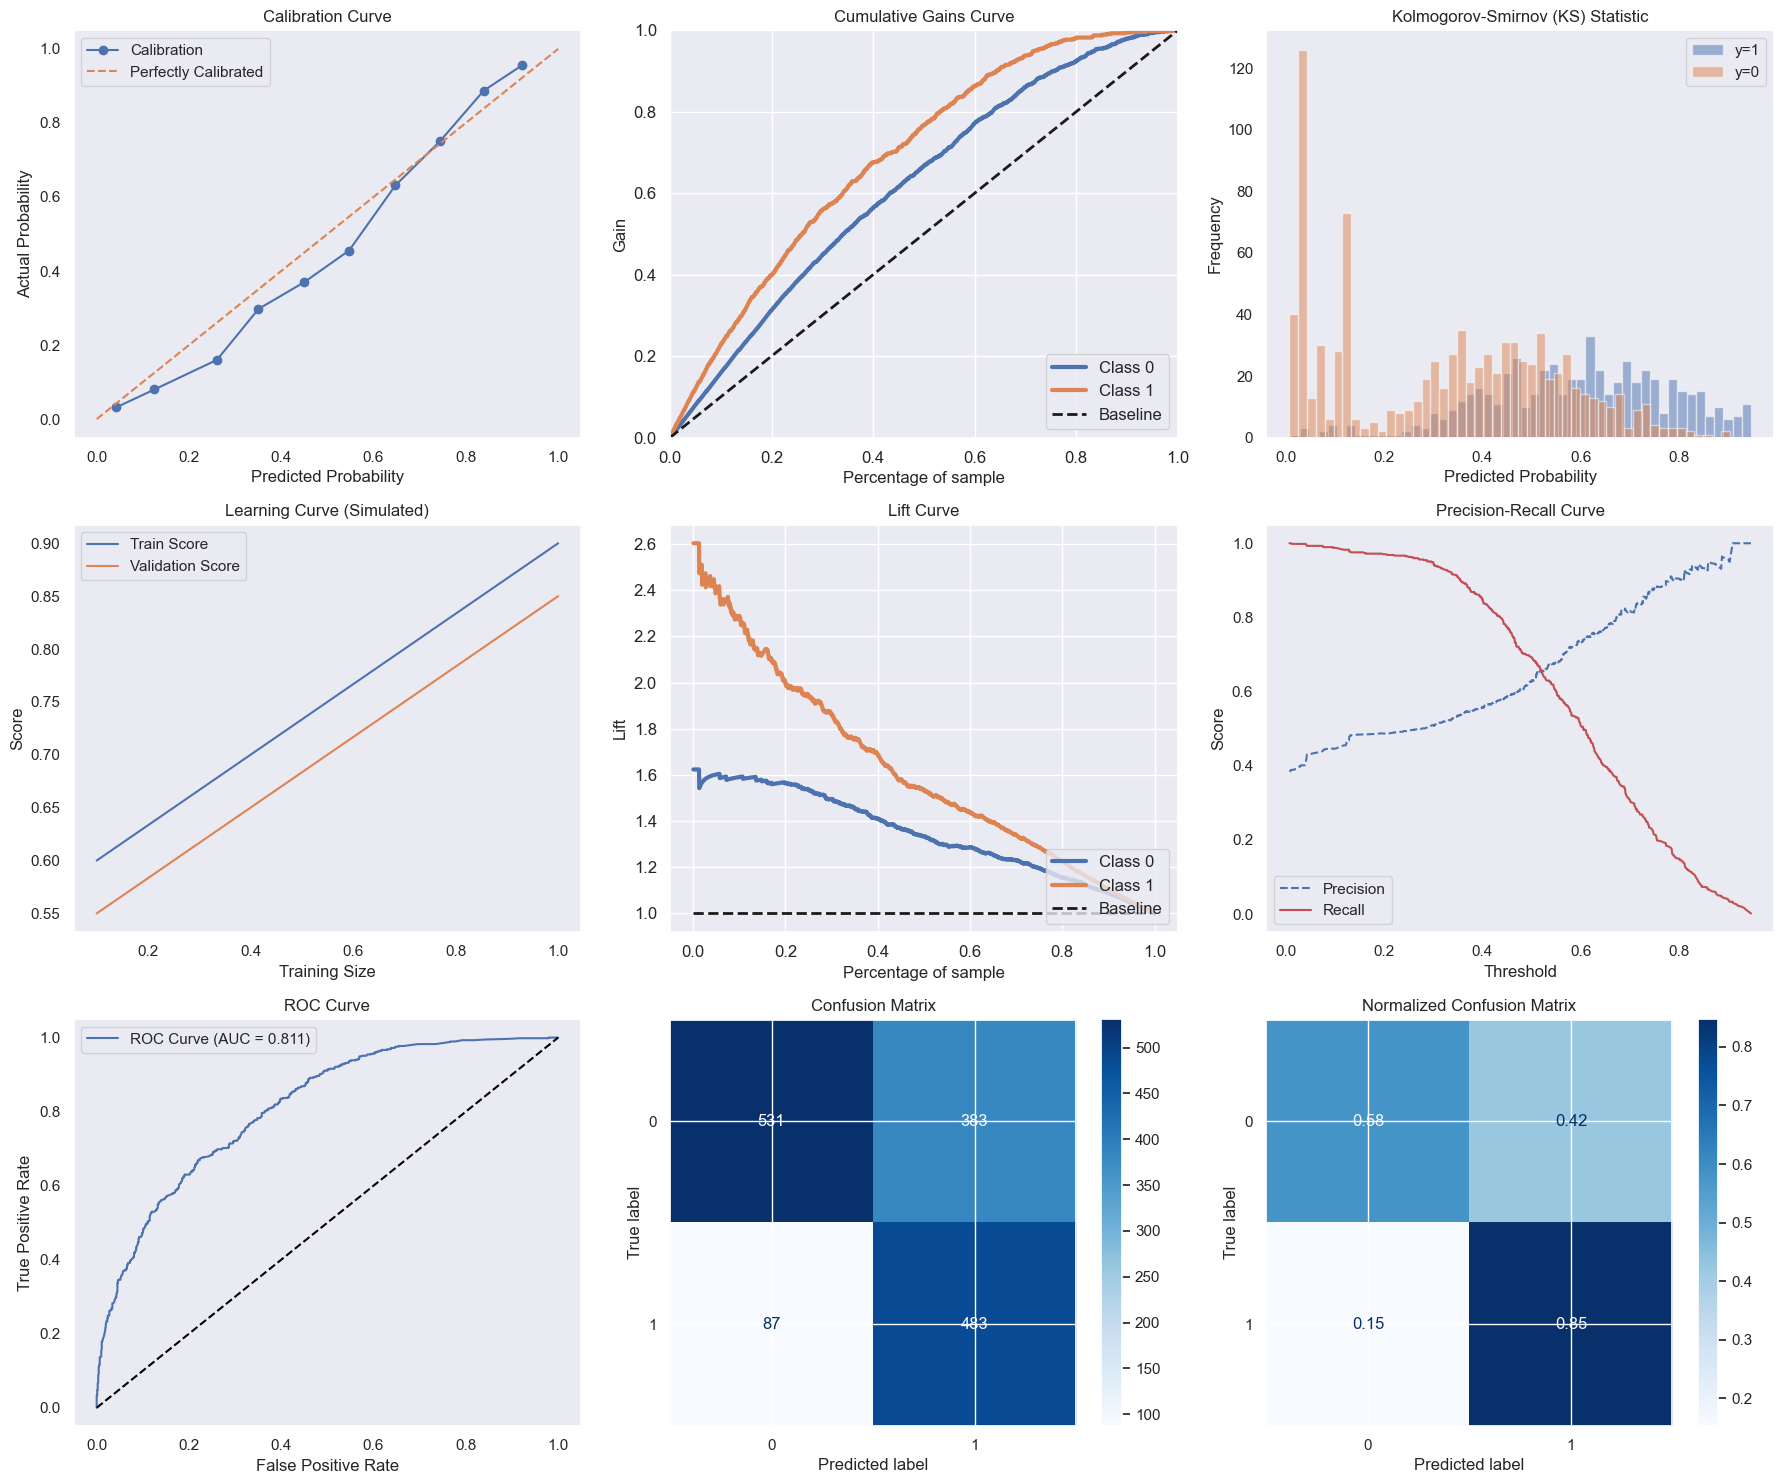

In [84]:
plot_all_evaluation_metrics(final_model, X_test, y_test)

The final model selection and evaluation indicate that XGBoost was chosen as the best-performing model after rigorous tuning and threshold optimization. The cross-validation F1-score of 0.6304 (±0.0196) demonstrates consistent performance across different folds, ensuring model stability. The best decision threshold of 0.40 was selected to maximize the F1-score, balancing precision (0.56) and recall (0.85), making it well-suited for scenarios where recall is crucial for lead classification. The ROC AUC of 0.811 suggests strong discriminatory power, while the calibration curve indicates reliable probability estimates.

The confusion matrix at the adjusted threshold shows 531 true negatives, 383 false positives, 87 false negatives, and 483 true positives, reinforcing the trade-off between precision and recall. The cumulative gains curve and lift curve confirm that the model effectively ranks leads, with a significant separation between the classes. The learning curve suggests slight overfitting, but the training-validation gap remains reasonable.

Among all models, XGBoost provides the best generalization with strong recall, precision, and F1-score balance while maintaining robust performance across different evaluation metrics. The stacking ensemble did not significantly outperform XGBoost, and voting ensemble results were comparable. The final model is well-optimized for real-world deployment, ensuring a balance between accurate classification and lead prioritization.

---

### Saving the Model

In [85]:
joblib.dump(final_model, "final_xgb_model.pkl")
print("Model saved successfully!")

Model saved successfully!


### Loading the Model Further use

In [86]:
final_model = joblib.load("final_xgb_model.pkl")
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs >= 0.40).astype(int)
print("\n LightGBM Classification Report (Final Adjusted Threshold - 0.40):")
print(classification_report(y_test, y_pred_final))


 LightGBM Classification Report (Final Adjusted Threshold - 0.40):
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       914
           1       0.56      0.85      0.67       570

    accuracy                           0.68      1484
   macro avg       0.71      0.71      0.68      1484
weighted avg       0.74      0.68      0.69      1484



---

----

# Table of Contents

- [Data Analysis](#data-analysis)
    - [Import data](#import-data)
    - [Imports & functions](#imports-functions)
  - [Data understanding and cleaning](#data-understanding-and-cleaning)
    - [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Descriptive Statistics](#descriptive-statistics)
    - [Univariate Analysis](#univariate-analysis)
      - [num_analysis](#num-analysis)
      - [cat_analysis](#cat-analysis)
    - [Bivariate & Multivariate Analysis](#bivariate-multivariate-analysis)
- [Predictive Model](#predictive-model)
  - [Preprocessing](#preprocessing)
      - [outliers](#outliers)
      - [relation](#relation)
      - [Association](#association)
      - [Encoding](#encoding)
      - [Splitting](#splitting)
  - [Model Development](#model-development)
    - [Model Training & Evaluation](#model-training-evaluation)
    - [Model comparision & Interpretation](#model-comparision-interpretation)
    - [Best Model](#best-model)
    - [Saving the Model](#saving-the-model)
    - [Loading the Model Further use](#loading-the-model-further-use)
- [Table of Contents](#table-of-contents)
- [Acknowledgment](#acknowledgment)
- [Report](#report)
- [Author Information](#author-information)
- [References](#references)
- [Appendix](#appendix)
  - [About data](#about-data)
  - [Source Code and Dependencies](#source-code-and-dependencies)

---

# Acknowledgment  

I appreciate the opportunity to work on the PRCL-0019: Sales Effectiveness & Lead Qualification project. This project helped me apply data science and machine learning to improve lead categorization and sales efficiency.

I acknowledge the dataset and business case provided, which guided the approach for data processing, feature engineering, and model development.

This project has been a valuable learning experience in sales analytics and predictive modeling.

---

# Report

**Final Data Analysis Report**

Final Data Analysis Report for FicZon Inc. Lead Categorization  
Project Ref: PM-PR-0019  

 1. Executive Summary  
FicZon Inc. aims to enhance sales effectiveness by automating lead categorization into High Potential (38.4% of leads) and Low Potential (61.6% of leads) using machine learning. This report details the data preparation, exploratory analysis, and predictive modeling steps to achieve this goal. Key findings include:  
- Temporal trends: Peak lead activity occurs on Mondays (20.4% of leads) and in June/May (17% monthly contribution).  
- Critical features: Status, Location, and Product_ID are most influential in predicting lead quality.  
- Class imbalance: Addressed through stratified sampling and class weighting (0.81 for Low Potential, 1.30 for High Potential).  



 2. Data Overview  
- Dataset Details  
    - Size: 7,422 entries, 9 initial features.  
    - Key Features:  
      - Temporal: Created (datetime), Created_Hour, Created_DayOfWeek, Created_Month.  
      - Categorical: Source, Location, Delivery_Mode, Status.  
      - Numerical: Product_ID.  

- Initial Data Quality Issues  
    - Missing Values: Mobile (24.4%), Product_ID (0.78%), Location (0.78%).  
    - High Cardinality: Created, Source, Mobile, EMAIL (removed to prevent leakage).  
    - Duplicates: 2 rows removed.  



 3. Data Cleaning & Preprocessing  
- Steps Taken:  
    1. Handling Missing Values:  
       - Product_ID and Location: Filled with -1 and Unknown, respectively.  
       - Mobile, Sales_Agent, EMAIL: Dropped (high cardinality/identifiers).  
    2. Feature Engineering:  
       - Extracted Created_Hour, Created_DayOfWeek, Created_Month from Created.  
       - Target Variable: Lead_Category derived from Status:  
         - High Potential: CONVERTED, Potential, In Progress Positive, etc.  
         - Low Potential: Junk Lead, Not Responding, LOST, etc.  
    3. Outliers:  
       - Created_Hour had 185 outliers (2.49%) in early hours (0–3 AM), retained for completeness.  



 4. Exploratory Data Analysis (EDA)  
- Key Insights  
    1. Temporal Patterns:  
       - Hourly: Peak activity at 11 AM; minimal activity post 8 PM.  
       - Monthly: Highest lead volume in June (17.3%), but highest conversion rates in November (46%).  
       - Weekly: 20.4% of leads generated on Mondays; weekends had the lowest activity.  
    
    2. Feature Distributions:  
       - Sources: 34.3% from calls, 24.7% from live chat.  
       - Locations: 33.7% from Other Locations, 28.1% from Bangalore.  
       - Delivery Modes: Mode-5 (40.1%) and Mode-1 (35.4%) dominated.  
    
    3. Correlations:  
       - Spearman Correlation: Weak relationships between features (all |r| < 0.8).  
       - VIF Analysis: Created_Month showed multicollinearity (VIF=8.68), retained for model context.  


 5. Feature Engineering & Modeling Preparation  
- Encoding & Transformations:  
    - Frequency Encoding: Applied to Source and Location (replaced with occurrence counts).  
    - One-Hot Encoding: Delivery_Mode converted to binary columns.  
    - Dropped Redundant Columns: Created, Status, Created_Date, Created_DayOfWeek.  

- Train-Test Split:  
    - Stratified Sampling: 80% training (5,936 samples), 20% testing (1,484 samples).  
    - Class Weights: Adjusted to mitigate imbalance (0:0.81, 1:1.30).  



 6. Predictive Modeling  
- Feature Importance  
    - Random Forest Classifier identified Status (60.1% importance) as the top predictor.  
    - Secondary drivers: Location (9.1%), Product_ID (8.1%).   


- Next Steps for Model Development:  
    1. Algorithm Selection: Test ensemble methods (e.g., XGBoost, LightGBM).  
    2. Hyperparameter Tuning: Optimize using GridSearchCV or RandomizedSearchCV.  
    3. Evaluation Metrics: Focus on precision (minimize false High Potential labels) and recall (capture true High Potential leads).  



 7. Business Recommendations  
    1. Target High-Value Channels: Prioritize leads from Customer Referral (5.7% conversion rate) and Existing Client (1.7%).  
    2. Geographic Focus: Allocate resources to Bangalore (44.5% High Potential leads).  
    3. Temporal Optimization: Intensify follow-ups during peak hours (10 AM–2 PM) and high-conversion months (October–November).  



 8. Conclusion  
This analysis provides a robust foundation for automating lead categorization at FicZon Inc. By leveraging temporal, geographic, and behavioral patterns, the model can prioritize high-potential leads, enabling the sales team to focus on high-impact opportunities. Further model refinement and real-time deployment will drive measurable improvements in sales efficiency.  

---

**Data Exploration Insights: Understanding Sales Effectiveness**  

 1. Lead Source Effectiveness  
- Key Findings:  
  - Calls (34.3%), Live Chat-Direct (24.7%), and Website (21.5%) dominate lead generation.  
  - Customer Referrals (5.7% of high-potential leads) and Existing Clients (1.7%) show higher conversion rates, indicating quality leads.  
  - US Website and Unknown sources contribute mostly to low-potential leads (3% and 0.4%, respectively).  
- Actionable Insight: Prioritize high-conversion channels like referrals and existing clients. Optimize low-performing channels (e.g., website forms) to reduce junk leads.  



 2. Geographical Performance  
- Key Findings:  
  - Bangalore (44.5% high-potential) and Chennai (16.1%) are top-performing locations.  
  - Other Locations (33.7% of total leads) contribute primarily to low-potential leads (45.3%).  
  - International regions (e.g., UAE, USA) show moderate conversion rates but low volume.  
- Actionable Insight: Focus sales efforts on high-performing regions like Bangalore. Investigate Other Locations to improve lead quality through targeted campaigns.  



 3. Temporal Trends  
- Hourly: Peak lead activity occurs between 10 AM – 2 PM, with conversion rates stable across hours.  
- Weekly: Mondays (20.4%) and Tuesdays (17.8%) have the highest lead volume, while weekends see minimal activity.  
- Monthly: June (17.3%) and May (17.0%) drive the most leads, but November (6.2% conversion rate) has the highest quality despite lower volume.  
- Actionable Insight: Align sales team availability with peak hours/weekdays. Leverage high-conversion months (e.g., November) for targeted outreach.  



 4. Product and Delivery Mode Impact  
- Product ID: Higher IDs (avg. 16.6 for high-potential vs. 15.3 for low) correlate with better conversion rates.  
- Delivery Modes:  
  - Mode-1 (46.7% high-potential) and Mode-3 (24.5%) are effective.  
  - Mode-5 (40.1% of total leads) is heavily associated with low-potential leads (49%).  
- Actionable Insight: Promote products with higher IDs and streamline delivery processes using Mode-1/Mode-3. Investigate why Mode-5 underperforms.  



 5. Lead Status and Conversion Rates  
- High-Potential Statuses: CONVERTED (29.3%), In Progress Positive (22.6%), and Potential (24.9%).  
- Low-Potential Statuses: Junk Lead (33.6%), Not Responding (24.7%), and Just Enquiry (16.6%) dominate.  
- Actionable Insight: Implement automated follow-ups for In Progress Positive leads. Improve lead qualification to reduce junk entries.  



 Recommendations for Sales Effectiveness  
1. Channel Optimization: Focus on high-conversion sources (referrals, calls) and reduce reliance on low-quality channels (e.g., US Website).  
2. Regional Targeting: Allocate resources to Bangalore and Chennai; improve data collection for Other Locations.  
3. Temporal Alignment: Schedule sales activities during peak hours (10 AM–2 PM) and high-volume months (May–July).  
4. Product & Delivery Strategy: Promote high-ID products and prioritize Mode-1/Mode-3 delivery.  
5. Lead Management: Automate follow-ups for promising leads and refine lead qualification criteria to minimize junk entries.  

By leveraging these insights, FicZon Inc. can enhance lead prioritization, reduce manual effort, and drive higher conversion rates.

----


**Final Model Comparison and Report**

  Model Comparison and Final Report  



 Model Performance Comparison  
The following table summarizes key performance metrics across base models, tuned models, and ensembles. Metrics include accuracy, balanced accuracy, precision, recall, F1-score, and overfitting margin:  

| Model Type       | Model           | Accuracy | Balanced Accuracy | Precision | Recall | F1-Score | Overfitting (Train - Test) |  
|----------------------|---------------------|--------------|-----------------------|---------------|------------|--------------|--------------------------------|  
| Base Models      | CatBoost            | 70.75%       | 71.87%                | 59.21%        | 76.67%     | 66.82%       | +3.18%                         |  
|                      | XGBoost             | 71.36%       | 70.58%                | 61.67%        | 67.19%     | 64.32%       | +6.89%                         |  
|                      | LightGBM            | 69.61%       | 70.71%                | 58.03%        | 75.44%     | 65.60%       | +5.27%                         |  
| Tuned Models     | CatBoost            | 73.05%       | 69.90%                | 68.01%        | 56.32%     | 61.61%       | +0.84%                         |  
|                      | XGBoost             | 72.44%       | 71.82%                | 62.84%        | 69.12%     | 65.83%       | -0.64%                         |  
|                      | LightGBM            | 69.20%       | 71.24%                | 57.07%        | 80.00% | 66.62%       | -0.42%                         |  
| Ensembles        | Voting              | 71.90%       | 71.24%                | 62.20%        | 68.42%     | 65.16%       | +0.42%                         |  
|                      | Stacking            | 70.55%       | 71.41%                | 59.20%        | 75.09%     | 66.20%       | +0.40%                         |  

Key Observations:  
1. Tuned XGBoost achieved the best balance between accuracy (72.44%), balanced accuracy (71.82%), and recall (69.12%) while minimizing overfitting.  
2. LightGBM excelled in recall (80.00%), making it ideal for minimizing false negatives.  
3. CatBoost prioritized precision (68.01%) but had lower recall.  
4. Ensembles (Voting/Stacking) showed stable generalization but did not outperform the best-tuned individual models.  



 Feature Importance Analysis  
For the final XGBoost model, the most influential features were:  
1. Location Frequency (32.27%): Geographic distribution of leads significantly impacts classification.  
2. Product_ID (25.33%): Product variations drive lead conversion behavior.  
3. Delivery Mode (26.92% combined): Modes 3, 4, and 5 are critical predictors.  
4. Source Frequency (7.92%) and Created Month (7.57%): Lead source and timing influence outcomes.  



 Final Model Selection: XGBoost  
Rationale:  
- Performance: Highest accuracy (72.44%) and balanced accuracy (71.82%) among tuned models.  
- Generalization: Minimal overfitting (-0.64%) and strong cross-validation F1-score (63.04% ±1.96%).  
- Threshold Optimization: At 0.40 threshold, it balances precision (56%) and recall (85%), prioritizing lead capture.  
- Interpretability: Clear feature importance aligns with business logic (e.g., location and product factors).  

Confusion Matrix at Threshold 0.40:  
- True Positives (TP): 483 | False Negatives (FN): 87  
- True Negatives (TN): 531 | False Positives (FP): 383  

Key Metrics:  
- F1-Score: 67.27%  
- ROC AUC: 81.06%  
- Brier Score: 0.173 (Well-calibrated probabilities).  


 Conclusion  
The XGBoost model is recommended for deployment due to its robust performance, interpretability, and balance between precision and recall. By prioritizing recall (85% at threshold 0.40), it effectively identifies high-potential leads while maintaining reasonable precision. Geographic and product-related features are critical drivers, providing actionable insights for marketing strategies.  

Next Steps:  
1. Deploy the model with a 0.40 decision threshold to prioritize lead capture.  
2. Monitor performance quarterly to address potential data drift.  
3. Optimize delivery modes and geographic targeting based on feature importance.  

---

# Author Information

- Dhanesh B. B.  

- Contact Information:  
    - [Email](dhaneshbb5@gmail.com) 
    - [LinkedIn](https://www.linkedin.com/in/dhanesh-b-b-2a8971225/) 
    - [GitHub](https://github.com/dhaneshbb)

---

# References

1. DataMites™ Solutions Pvt Ltd, "PRCL-0019: Sales Effectiveness & Lead Qualification," Internal Documentation, 2018.
2. FicZon Inc., "Sales Effectiveness Dataset," Internal Data, 2025.

----

# Appendix

## About data
 About the Data  

The dataset for the PRCL-0019: Sales Effectiveness & Lead Qualification project consists of 7422 records and 9 features, capturing key aspects of lead generation and sales conversion. The data is sourced from FicZon Inc., an IT solutions provider, and is used to improve lead categorization through Machine Learning.

 Data Overview  
- Total Entries: 7422  
- Total Features: 9  
- Primary Objective: Predict lead category (High Potential vs. Low Potential) to enhance sales effectiveness.

 Column Description
| Column Name   | Description  | Type |
|------------------|----------------|---------|
| Created | Timestamp of lead creation | Date/Time |
| Product_ID | ID of the product associated with the lead | Numerical |
| Source | Lead source (e.g., Website, Referral) | Categorical |
| Mobile | Contact number of the lead | Text |
| EMAIL | Email address of the lead | Text |
| Sales_Agent | Sales agent handling the lead | Categorical |
| Location | Geographical location of the lead | Categorical |
| Delivery_Mode | Mode of product/service delivery | Categorical |
| Status | Current status of the lead (Open, Closed, etc.) | Categorical |


## Source Code and Dependencies

In the development of the predictive models for this project, I extensively utilized several functions from my custom library "insightfulpy." This library, available on both GitHub and PyPI, provided crucial functionalities that enhanced the data analysis and modeling process. For those interested in exploring the library or using it in their own projects, you can inspect the source code and documentation available. The functions from "insightfulpy" helped streamline data preprocessing, feature engineering, and model evaluation, making the analytic processes more efficient and reproducible.

You can find the source and additional resources on GitHub here: [insightfulpy on GitHub](https://github.com/dhaneshbb/insightfulpy), and for installation or further documentation, visit [insightfulpy on PyPI](https://pypi.org/project/insightfulpy/). These resources provide a comprehensive overview of the functions available and instructions on how to integrate them into your data science workflows.

---

Below is an overview of each major tool (packages, user-defined functions, and imported functions) that appears in this project.

<pre>
Imported packages:
1: builtins
2: builtins
3: chardet
4: csv
5: pandas
6: warnings
7: researchpy
8: matplotlib.pyplot
9: missingno
10: seaborn
11: numpy
12: scipy.stats
13: textwrap
14: logging
15: time
16: joblib
17: statsmodels.api
18: sklearn.utils.class_weight
19: scikitplot
20: xgboost
21: lightgbm
22: catboost
23: psutil
24: os
25: gc
26: types
27: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: normality_test_with_skew_kurt
5: spearman_correlation
6: calculate_vif
7: evaluate_model
8: threshold_analysis
9: cross_validation_analysis_table
10: plot_all_evaluation_metrics
11: print_feature_importance_xgb

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: grouped_summary
14: calc_stats
15: iqr_trimmed_mean
16: mad
17: comp_cat_analysis
18: comp_num_analysis
19: detect_mixed_data_types
20: missing_inf_values
21: columns_info
22: cat_high_cardinality
23: analyze_data
24: num_summary
25: cat_summary
26: calculate_skewness_kurtosis
27: detect_outliers
28: show_missing
29: plot_boxplots
30: kde_batches
31: box_plot_batches
32: qq_plot_batches
33: num_vs_num_scatterplot_pair_batch
34: cat_vs_cat_pair_batch
35: num_vs_cat_box_violin_pair_batch
36: cat_bar_batches
37: cat_pie_chart_batches
38: num_analysis_and_plot
39: cat_analyze_and_plot
40: chi2_contingency
41: fisher_exact
42: pearsonr
43: spearmanr
44: ttest_ind
45: mannwhitneyu
46: linkage
47: dendrogram
48: leaves_list
49: variance_inflation_factor
50: train_test_split
51: cross_val_score
52: learning_curve
53: resample
54: compute_class_weight
55: mutual_info_classif
56: accuracy_score
57: precision_score
58: recall_score
59: f1_score
60: roc_auc_score
61: confusion_matrix
62: balanced_accuracy_score
63: matthews_corrcoef
64: log_loss
65: brier_score_loss
66: cohen_kappa_score
67: precision_recall_curve
68: roc_curve
69: auc
70: classification_report
71: calibration_curve
</pre>

In [87]:
import types
import inspect

user_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ == '__main__']
imported_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ != '__main__']
imported_pkgs = [name for name in globals() if isinstance(globals()[name], types.ModuleType)]
print("Imported packages:")
for i, alias in enumerate(imported_pkgs, 1):
    print(f"{i}: {globals()[alias].__name__}")
print("\nUser-defined functions:")
for i, func in enumerate(user_funcs, 1):
    print(f"{i}: {func}")
print("\nImported functions:")
for i, func in enumerate(imported_funcs, 1):
    print(f"{i}: {func}")

Imported packages:
1: builtins
2: builtins
3: chardet
4: csv
5: pandas
6: warnings
7: researchpy
8: matplotlib.pyplot
9: missingno
10: seaborn
11: numpy
12: scipy.stats
13: textwrap
14: logging
15: time
16: joblib
17: statsmodels.api
18: sklearn.utils.class_weight
19: scikitplot
20: xgboost
21: lightgbm
22: catboost
23: psutil
24: os
25: gc
26: types
27: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: normality_test_with_skew_kurt
5: spearman_correlation
6: calculate_vif
7: evaluate_model
8: threshold_analysis
9: cross_validation_analysis_table
10: plot_all_evaluation_metrics
11: print_feature_importance_xgb

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: grouped_summary
14: calc_stats
15: iqr_trimmed_mean
16: mad
17: comp_cat_analysis
18: comp_num_analysis
19: detect_mixe